<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [2]:
%%capture
pip install pyswarms

In [3]:
%%capture
pip install scipy

In [4]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 20000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 4000 # Valor para o custo da manutenção preventiva

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_pso_quarto_cenario'
NOME_ARQUIVO_CICLO_TEMPO_SEVERIDADE = 'ciclo_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '04'

In [7]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [8]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [9]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [10]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [11]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [12]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [13]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [14]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [15]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [16]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [17]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [18]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2023-10-30 01:50:16,327 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-.0824
2023-10-30 01:50:16,464 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08244980553174067, best pos: [148.26856132   1.00407353   0.38784231]


In [19]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.2685613223698
beta: 1.0040735251859763
theta: 0.3878423057873866

Tempo de Convergência para a primeira etapa: 0.01263880729675293 segundos


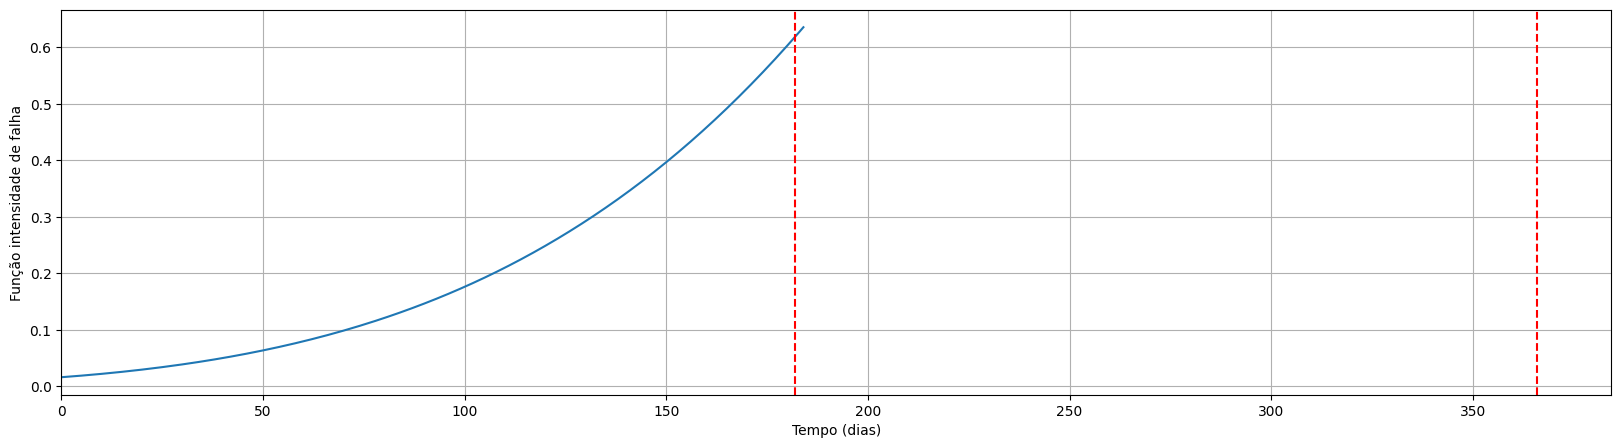

Fator ajuste:  [0.3214806665999568, 0.3214806665999568, 0.3214806665999568, 0.3214806665999568, 0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.3214806665999568, 0.17627715012873213, 0.3214806665999568, 0.17627715012873213, 0.3214806665999568, 0.3214806665999568, 0.3214806665999568]


In [20]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [21]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [22]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-30 01:50:17,985 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  10%|█         |10/100, best_cost=2.04e+5<ipython-input-21-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  10%|█         |10/100, best_cost=2.04e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 32, 78, 158, 229, 289, 313, 417, 424, 480, 551, 597, 651, 681]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.2523959075814014, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135]
Media de falhas:  [0, 0.0004538807253345515, 0.0199401627131834, 0.8760749438149352, 4.980494491192487, 12.225219363717144, 18.900860720424365, 71.62594292181691, 78.86161329161, 136.15441986668895, 260.89261320901096, 432.37777851860517, 841.3468504693573, 1133.115804355825, 1420.0529272081908]
Custo =  478158.07415247604


Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 47, 89, 167, 223, 249, 326,

pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 31, 83, 99, 139, 177, 221, 286, 356, 368, 435, 556, 599, 648, 701]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.2523959075814014]
Media de falhas:  [0, 0.00038700759060861294, 0.02891555658171652, 0.06737120045857438, 0.3864111651788803, 1.6089052547309781, 3.431091645633208, 13.605004782281359, 41.12252573527475, 51.1534755588086, 95.41060296870916, 373.1068634257447, 486.14823417131083, 740.6730238173991, 1288.193877464711, 1463.9477042573915]
Custo =  432105.57657429564


Número de ciclos de manutenção: 12 2
Tempos para man

pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=1.37e+5



Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 32, 85, 175, 277, 370, 424, 539, 559, 599]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.0004538807253345515, 0.03242686027473646, 1.475698968280792, 13.349930609578667, 67.97587301119009, 101.12023501967735, 335.3888847701602, 377.04915179438757, 600.103974257737, 1545.8835852880597]
Custo =  274644.5675326618


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 85, 93, 161, 298, 301, 367, 420, 463, 531, 558, 598, 633]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=1.37e+5

Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.2523959075814014]
Media de falhas:  [0, 0.0006153506898571087, 0.033341342567153626, 0.043355660769723414, 98.5500662664417, 112.31645940772368, 426.86643136980837, 600.7402320651563, 1152.4281510425496, 1208.482678258142, 1424.0245367609627]
Custo =  459449.27459989855


Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 35, 86, 143, 384, 410, 470, 554, 599, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014]
Media de falhas:  [0, 0.0007117455147182014, 0.03272455393901811, 0.

pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=1.37e+5



Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 87, 176, 382, 404, 473, 558, 599, 600]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.06880740554259993, 1.050977744407981, 75.79893089103697, 101.5389810140752, 192.75371847023047, 409.1353358977391, 566.073847352292, 570.3467832776186, 1894.331382608752]
Custo =  359916.81139731815


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 87, 92, 380, 404, 420, 470, 557, 599, 600, 693]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.25239590758140

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.37e+5
2023-10-30 01:50:19,164 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405572 2.3373612  3.98610107 5.92656341 2.03044862 1.07141874
 2.12063888 2.00008238 4.41004302 6.35340689 1.65020991 2.60814091
 3.89964811 3.49637221 4.41334361 5.04923802 2.04679424 3.7179972
 3.20956349 1.90863071 3.38705796 3.04676262 6.14450968 6.7106292 ]
2023-10-30 01:50:19,166 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 2
Tempos para manutenções preventivas: [0, 86, 174, 353, 372, 411, 473, 546, 598, 710]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.0649275348374997, 0.9924543431026525, 49.47904066460914, 65.52883170581137, 111.0507778158503, 194.7649768704332, 369.62430521468286, 561.9109949413476, 1307.2159674228965, 1572.1911575970016]
Custo =  445398.63638993737


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 34, 87, 147, 282, 329, 331, 376, 408, 553, 598]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,187 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95313433 2.34053731 3.99557522 5.93551716 2.03019387 1.07150274
 2.11405443 2.0193514  4.43318946 6.35329229 1.65121835 5.04489711
 3.89876531 3.49646255 4.41266927 5.03056248 2.04712557 2.76772794
 3.21777739 1.90900537 3.39230537 3.04747992 4.90550354 6.71055293]
2023-10-30 01:50:19,190 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 88, 171, 334, 379, 407, 430, 527, 557, 599, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014]
Media de falhas:  [0, 0.07287077247597928, 0.8879104858172286, 36.79622118219451, 73.16828007670514, 106.06930207348955, 129.8262591437719, 317.59105107806306, 377.79250668940927, 538.1533943265141, 1123.69051173459, 1593.9118238343926]
Custo =  450692.1791411027


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9521031  2.34096678 3.99060526 5.95159195 2.03021134 1.07090961
 2.12311009 2.01191239 4.4353224  6.35354918 1.65119527 2.78565504
 3.89726503 3.49595529 4.41358151 5.03910344 2.04666731 3.28444547
 3.21761711 1.90896802 3.39092782 3.05298198 1.77051612 6.7104387 ]
2023-10-30 01:50:19,215 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 88, 153, 354, 385, 406, 435, 531, 561, 598, 652, 715]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.07287077247597928, 0.4819666443997534, 53.0898982062369, 81.6257549227308, 106.81060189146253, 137.56694046806194, 329.9923104761077, 391.9806475553529, 534.0697981891672, 818.4992324108189, 1507.8193316932009, 1644.7068729696325]
Custo =  552535.0657618393


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,228 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95151935 2.34035055 3.98517609 5.9610569  2.03023015 1.07045457
 2.13081498 2.0046381  4.43568613 6.35376422 1.65102831 0.72769759
 3.8965037  3.49556325 4.41436124 5.04861078 2.04625734 3.83195895
 3.21698351 1.9089072  3.38858686 3.05678187 4.87996135 6.71034875]




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 88, 289, 335, 404, 436, 451, 509, 534, 562, 597, 638]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.07287077247597928, 17.065759293493766, 32.44592331226576, 65.70364163148048, 99.60985836162101, 118.97103989819917, 194.32835407342742, 237.04985705840122, 361.5776896760374, 495.7463030328736, 699.2708450820523, 1723.4673673769496]
Custo =  461523.8802822758


2023-10-30 01:50:19,240 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95112628 2.33977932 3.98056277 5.96318393 2.03028296 1.07020458
 2.13516816 1.99694439 4.43488585 6.35395012 1.65079664 6.05842095
 3.89645682 3.49530577 4.4148665  5.0573498  2.04593726 4.30787266
 3.21598006 1.90877278 3.38602989 3.05985211 0.1433396  6.71030502]
2023-10-30 01:50:19,251 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 89, 138, 239, 403, 434, 465, 508, 536, 562, 596, 600]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.07712408002188854, 0.2833483234110446, 6.430853909934799, 89.25094227603664, 136.1905283391891, 179.1781120482267, 236.5560152524664, 284.7980148309481, 401.16680017932543, 530.9386438402864, 547.8962044275635, 1871.8808037586969]
Custo =  441060.9524821831


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95163629 2.3391369  3.97721727 5.95734759 2.03034683 1.07029675
 2.13752788 1.99010437 4.43190962 6.35400739 1.65048117 4.38182835
 3.89655673 3.49520945 4.41498593 5.06366645 2.04585726 4.73222506
 3.21406158 1.90861968 3.38375793 3.06001488 3.02189182 6.71027909]
2023-10-30 01:50:19,272 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 27, 89, 141, 233, 327, 402, 426, 477, 508, 537, 558, 595, 603, 711]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 0.4468591224058634, 5.643517605739793, 22.996558133068888, 91.408766675647, 126.04462677213334, 199.82557746470437, 242.40363677253052, 292.6330858850698, 385.3806662859222, 524.5596315413209, 558.8046963987255, 1593.0808390241873, 1764.9969369389341]
Custo =  575956.5730453036


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95271867 2.33849664 3.97516463 5.94461898 2.03041362 1.07067119
 2.13694599 1.98601106 4.42876954 6.35401366 1.65011659 2.74362558
 3.89710334 3.49521614 4.41492444 5.06676604 2.04603989 4.89910727
 3.21159149 1.90848374 3.38252488 3.05907083 5.51954398 6.71035768]
2023-10-30 01:50:19,286 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 24, 89, 104, 229, 324, 357, 402, 508, 537, 554, 595, 608]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.0001070787645446024, 0.049010574534346305, 0.09405221094186011, 5.862759450071275, 22.68335503060048, 44.64168865679174, 91.2826749923617, 330.0573876215625, 403.18943285916316, 477.0430262599806, 629.7041563905921, 686.5051758718942, 1952.2709479020325]
Custo =  444727.62376968906


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95377368 2.33783956 3.97382357 5.92903377 2.03048232 1.07118228
 2.13306497 1.98633373 4.42520369 6.35394874 1.64980181 1.26595819
 3.89812124 3.49544739 4.41452224 5.06630162 2.04633995 4.91900627
 3.20904061 1.908391   3.38143191 3.05647327 0.19718452 6.71048679]
2023-10-30 01:50:19,299 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 23, 59, 114, 139, 151, 227, 292, 320, 402, 509, 534, 549, 595, 613]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 8.647884093091122e-05, 0.005073538631748391, 0.16671367481538435, 0.4893231895716378, 0.6120373870247785, 6.109106573163095, 17.236441998265175, 29.341586816466823, 66.79332538481526, 309.10884915520194, 371.4321962722679, 434.6445849863136, 603.7658708576524, 684.0422930623462, 1912.1509004953568]
Custo =  433390.11682140734


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,308 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95475796 2.33716688 3.97459415 5.91469533 2.03053901 1.07168932
 2.12921935 1.986731   4.41837899 6.35377083 1.64963249 0.08726242
 3.8994637  3.49567826 4.41395292 5.06280642 2.04664998 4.83047071
 3.20676579 1.90835376 3.38094388 3.05313152 2.06840146 6.71062834]
2023-10-30 01:50:19,309 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 22, 57, 102, 126, 154, 206, 225, 317, 402, 531, 544, 595, 618, 718]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 6.918164493070931e-05, 0.004294009041001147, 0.09203627882522529, 0.297035166412501, 0.573243221225689, 2.6801622081695715, 4.684243150050532, 31.97057239412483, 106.35466219291727, 434.5850588043224, 470.7635000666684, 655.9206150966546, 760.6197639683079, 1778.5639510674564, 1888.779836818829]
Custo =  514879.52992153564


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9554686  2.33660511 3.97657283 5.90245355 2.03057554 1.07209569
 2.12358666 1.9898514  4.4119376  6.3535062  1.64954423 6.71381879
 3.90069467 3.49601517 4.41339157 5.0593248  2.04695971 4.59070796
 3.20543814 1.90832701 3.38072801 3.04891718 3.82219643 6.71075594]
2023-10-30 01:50:19,320 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 22, 57, 202, 227, 290, 314, 389, 403, 448, 528, 540, 596, 621, 701]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 6.918164493070931e-05, 0.004294009041001147, 3.657166862691395, 6.26937308438671, 20.960023030327484, 30.764950655539298, 61.116353273683686, 77.91464112507227, 128.9899782466828, 292.2580221377926, 324.76195913624633, 526.9505515358079, 642.4478000202984, 1414.9177281435223, 1671.8042408681417]
Custo =  527252.9507907156


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,329 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95587002 2.33617617 3.98093248 5.89477898 2.03057517 1.07240356
 2.11791287 1.99544526 4.40611924 6.35325086 1.64948057 5.66580736
 3.90165545 3.49634718 4.41287365 5.05332722 2.04720132 4.21097376
 3.20466682 1.90830368 3.38127054 3.04472702 5.14196268 6.71083858]
2023-10-30 01:50:19,330 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 24, 58, 90, 200, 229, 313, 386, 404, 445, 476, 526, 597, 623, 709]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.0001070787645446024, 0.0044807317361110315, 0.045613993765281885, 3.6258181972726438, 5.759198451694305, 30.263699385563854, 86.5783129784023, 108.0131381339174, 153.8696105211151, 201.2043706201916, 310.2690605716207, 484.4115283187266, 605.8149641422467, 1464.2137957405023, 1653.418534534958]
Custo =  501124.4002411519


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,346 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95583907 2.33590382 3.98633934 5.89579082 2.03056797 1.07241162
 2.11349568 2.00122061 4.40170862 6.3530222  1.64950686 4.17130519
 3.90242039 3.49664655 4.41250801 5.0477876  2.04739038 3.75658621
 3.20526291 1.90835028 3.38333406 3.04115819 5.64234596 6.71088633]
2023-10-30 01:50:19,347 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 25, 92, 200, 233, 285, 313, 384, 404, 445, 464, 524, 597, 624, 630]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00013143416772731266, 0.05767839833328498, 2.9621025384005613, 6.588285103343033, 18.569753079499094, 29.60692216540341, 68.05610214083399, 91.66328385143093, 137.51975623862864, 164.68728919112453, 289.9386367343294, 468.30205870069807, 594.8906295698604, 640.2895473697073, 1406.6069563730775]
Custo =  444573.2728190461


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95572858 2.33601332 3.99113595 5.90172881 2.03055669 1.07240181
 2.11118256 2.00635595 4.39956688 6.35285058 1.64959956 2.44565799
 3.90229192 3.49689714 4.41229483 5.04296411 2.04739081 3.34746017
 3.20624283 1.90842648 3.38560487 3.03889977 5.42799202 6.7108588 ]
2023-10-30 01:50:19,361 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 27, 89, 201, 237, 314, 350, 381, 405, 452, 523, 598, 624, 639]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 3.080742954786048, 6.01332684452435, 29.6271103018316, 51.34832811194873, 78.67006416119935, 106.7894705733354, 161.78809362047727, 304.41410605508923, 488.24353468060434, 610.4449112712167, 727.6259687890694, 1437.4649632942856]
Custo =  436690.2547341355


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95517484 2.33619823 3.99460316 5.91371158 2.03053895 1.07217049
 2.10952795 2.0096585  4.39773976 6.35272189 1.64971187 0.91536771
 3.9019854  3.49701365 4.41220392 5.04007217 2.04727539 3.05561891
 3.20753558 1.90851903 3.38776682 3.03711675 4.64442403 6.71078575]
2023-10-30 01:50:19,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 29, 89, 141, 151, 203, 315, 359, 380, 406, 522, 598, 620, 646]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 0.4451086348516168, 0.5959146938525453, 2.5728357385680987, 19.475792764070977, 47.88529507467726, 67.06532511899894, 81.51442489700293, 286.8393463556009, 551.7827585407572, 653.5113985326594, 859.4400891980602, 1523.8735233992943]
Custo =  423163.4695137295


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 89, 116, 207, 292, 317, 380, 406, 523, 598, 617, 652, 705]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.07712408002188854, 0.1364823236050567, 3.1943045349041053, 21.28891528265101, 31.854951484720736, 79.32125839333841, 109.82757804723575, 318.1157765528933, 580.2059465996509, 666.9942114831591, 947.8942476079833, 1334.5280052208905, 1557.865511272946]
Custo =  551400.9499712992


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95467489 2.33655225 3.99575799 5.92785444 2.03051101 1.07190204
 2.10856894 2.00993117 4.39926753 6.35272695 1.64992569 0.00843478
 3.90137259 3.4970891  4.41233224 5.03992753 2.04710439 2.90348307
 3.20915494 1.90863007 3.38966591 3.03665233 3.57708154 6.71071747]
2023-10-30 01:50:19,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9541126  2.33699021 3.99477128 5.9404437  2.03046919 1.07151944
 2.1089138  2.00766887 4.40314904 6.3527669  1.65014629 6.36877133
 3.90051473 3.49703993 4.41268084 5.0406494  2.04689805 2.95808326
 3.21062364 1.90



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 88, 284, 319, 381, 406, 527, 543, 598, 613, 655, 692]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.07287077247597928, 15.490544418156404, 25.49487312963919, 72.950094297682, 102.4115464741523, 322.8197172369805, 366.6376048727873, 568.5032984814138, 635.9115078088811, 972.9610796783772, 1231.804640125162, 1562.096779371946]
Custo =  582851.6331572379


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95359958 2.33741437 3.9930505  5.94811832 2.03042557 1.07115186
 2.11167807 2.00447619 4.40869405 6.35293284 1.65034899 5.56913553
 3.89967864 3.4969207  4.41318496 5.04269383 2.04670149 3.17922965
 3.21165995 1.90881824 3.39190577 3.03964164 0.19424554 6.71055095]




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 88, 127, 282, 321, 345, 382, 406, 531, 548, 597, 609, 657, 701]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.07287077247597928, 0.1921776663876573, 16.665719124595157, 32.754834180550574, 47.246160071537375, 79.31611902530115, 98.82661490488289, 331.79035877563456, 379.97797191490423, 561.2742590934155, 614.1919344894429, 998.0199167472331, 1317.6844515341124, 1574.5709642587321]
Custo =  597449.8907793222


2023-10-30 01:50:19,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95323363 2.33779124 3.99066886 5.95286879 2.03039092 1.07083543
 2.11427596 2.00040505 4.41403984 6.35319466 1.65050484 4.40435392
 3.89892526 3.49680463 4.41364552 5.04627426 2.04653637 3.40871926
 3.21242244 1.90886552 3.39136716 3.04289308 6.4737653  6.71048597]
2023-10-30 01:50:19,421 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 89, 288, 323, 384, 406, 534, 552, 597, 605, 653]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.07712408002188854, 16.64110681748943, 27.180391473847628, 75.6849320879734, 101.95365682859531, 344.6269488064442, 397.0338781215762, 565.2144825063655, 599.920869337712, 974.1437035099061, 1591.8264557876491]
Custo =  467426.78209504427


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 89, 279, 324, 339, 385, 405, 537, 554, 596, 603, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.07712408002188854, 13.948343878491924, 27.074642909845814, 35.90336897346803, 75.45595323461811, 86.6642425673718, 340.6277172412682, 390.9980680834961, 548.0705634380928, 578.1130609812315, 868.5868049907378, 1559.1279115215457]
Custo =  461040.1415509576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95299747 2.33800389 3.98766661 5.95203152 2.03037518 1.07068198
 2.11784199 1.99665094 4.41799552 6.3534405  1.65061983 2.82077793
 3.89830246 3.49663853 4.41397444 5.05011723 2.04645388 3.68520737
 3.21275892 1.90889196 3.3897985  3.04638959 5.09693318 6.71044626]
2023-10-30 01:50:19,430 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,438 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95280507 2.33812573 3.98458475 5.94509784 2.03036734 1.07074354
 2.12162187 1.99350558 4.41956892 6.35365385 1.65062207 1.35492355
 3.89786317 3.49643245 4.41423127 5.05337658 2.04641563 3.94014977
 3.21272015 1.90



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 29, 89, 163, 325, 387, 404, 509, 539, 555, 596, 603, 632, 714]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 0.9833624029371769, 32.68234403520811, 58.107153674186094, 78.44079495834673, 249.9554961501039, 326.55462051870353, 396.80307120323005, 550.5252264681765, 580.5677240113151, 788.7840473066576, 1382.300150510217, 1528.0016655040693]
Custo =  631506.8941097427


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,446 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95278553 2.33815477 3.98184732 5.93724235 2.03037923 1.07095666
 2.1248613  1.99102716 4.41964814 6.35383181 1.65057832 0.09993132
 3.89753393 3.49623148 4.41421906 5.05569508 2.0464749  4.10370639
 3.21266569 1.9088152  3.38575872 3.05229307 1.23338399 6.71048922]
2023-10-30 01:50:19,447 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 27, 89, 121, 239, 325, 388, 404, 453, 509, 538, 555, 596, 603]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 0.19662305988668477, 6.9334889817072645, 36.29333262812703, 88.20748752262125, 107.42983502117777, 164.92559152682543, 269.6281648876169, 320.2410915142512, 394.63947067540386, 548.3616259403502, 578.4041234834889, 1880.8448830525062]
Custo =  450293.87358227326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,456 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95277783 2.33798785 3.97960292 5.92779719 2.0303952  1.07116433
 2.12688669 1.991325   4.41750599 6.35399014 1.65050739 6.034669
 3.89737831 3.49609229 4.41396435 5.05697054 2.04660792 4.22983921
 3.21261576 1.90873676 3.38410917 3.05311863 5.80629478 6.71055252]
2023-10-30 01:50:19,457 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 27, 119, 135, 236, 273, 325, 389, 403, 459, 509, 537, 553, 596, 606, 691]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00019342286838261772, 0.22684479664862967, 0.36915066666522767, 4.9388459856416596, 12.707142778595662, 33.80998440010913, 86.9020141400253, 103.70030199141388, 171.59432621061572, 266.7158762204331, 315.3266818814914, 384.54997403776815, 544.9553359631466, 588.4035822778873, 1351.219206936357, 1689.4935836308305]
Custo =  566442.5401651406

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,464 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95308094 2.33767331 3.97878826 5.91919247 2.03041111 1.07137001
 2.12748944 1.99167908 4.41495786 6.35397876 1.65036156 4.12718572
 3.89743221 3.49599714 4.41371515 5.05785142 2.04673499 4.21089979
 3.21214513 1.90864053 3.38301686 3.05339552 2.97158933 6.7106261 ]
2023-10-30 01:50:19,465 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 26, 119, 163, 235, 270, 324, 389, 403, 463, 535, 551, 596, 609]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00016003755384037956, 0.23015190812613387, 0.9106037865760966, 7.161765641749317, 10.65292302326346, 32.053586108888034, 85.74027735697273, 102.5385652083613, 177.04269967595576, 335.7563927564004, 367.4817369366503, 534.5008203581218, 591.6815006750983, 1849.9952115948122]
Custo =  400281.70111213997


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,478 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95345558 2.33736271 3.97937021 5.91181706 2.03043093 1.07156115
 2.12689434 1.99345289 4.41199013 6.35396143 1.6502     2.28733296
 3.89758626 3.49597157 4.41338853 5.05810455 2.04685108 4.13022094
 3.21156259 1.90855319 3.38211569 3.05355869 0.2519318  6.71069261]
2023-10-30 01:50:19,479 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 26, 101, 235, 321, 389, 403, 463, 532, 548, 597, 611]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00016003755384037956, 0.09446129410774332, 6.837638891899265, 21.819348046002695, 77.25502977336092, 94.0533176247495, 168.55745209234396, 318.30542475687656, 349.33564157062034, 530.6319287491316, 592.875883564688, 1836.166816019581]
Custo =  394355.1081055475


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 26, 89, 108, 236, 272, 319, 388, 404, 463, 529, 545, 597, 614]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00016003755384037956, 0.04714399826063278, 0.11065979643174054, 6.795171212574826, 14.283763880006216, 32.36794456067366, 87.75579433092284, 106.97814182947936, 180.46920711579855, 321.4883698184759, 351.8349659600278, 542.7906478146855, 619.3048111688674, 1839.7619218040763]
Custo =  400962.39571398403


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95390033 2.33708303 3.98161719 5.90618378 2.03045284 1.07169114
 2.1259798  1.99674773 4.40903181 6.35388201 1.65005481 0.66058254
 3.89793369 3.49602485 4.41308952 5.05815083 2.04694355 4.04172522
 3.21063584 1.90849375 3.38190101 3.05254006 4.33068918 6.71075016]
2023-10-30 01:50:19,488 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 27, 89, 102, 125, 208, 238, 278, 317, 387, 404, 460, 527, 542, 597, 616, 692]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 0.08322285459653611, 0.2200827464981011, 2.517118121244915, 5.096211232990023, 14.001161065165576, 29.25866833315823, 84.58463546919994, 104.91827675336057, 173.43530885380196, 313.9449739933374, 341.8310254316052, 542.2970683930718, 628.5145158962242, 1330.44304082178

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,496 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95433191 2.3368427  3.9838611  5.90446973 2.03047163 1.07175475
 2.12450444 2.00012276 4.40652395 6.35379519 1.64995728 6.54359737
 3.89847076 3.49612112 4.41289644 5.05674942 2.04699008 3.87937671
 3.20971871 1.90847908 3.38214601 3.05127978 1.00740879 6.71077938]
2023-10-30 01:50:19,497 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,504 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95467159 2.33665065 3.98632272 5.90391769 2.03048544 1.07176235
 2.12229068 2.00314852 4.4050419  6.35360873 1.64993601 4.86131167
 3.89902463 3.49625241 4.4128161  5.05479617 2.04702635 3.72921167
 3.20888739 1.90



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 27, 89, 128, 162, 205, 283, 315, 387, 404, 456, 526, 540, 597, 617, 695]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 0.2650861276118874, 0.8191688927940468, 2.624976718398891, 10.759082137453369, 23.42784188524687, 79.84197106109013, 100.17561234525077, 162.29633800061424, 306.73817459700234, 332.43928110616696, 539.1640852652413, 630.2907971724787, 1360.2660034698051, 1666.4046406034236]
Custo =  511302.59455461585

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95489884 2.33649255 3.98850168 5.90399798 2.03048929 1.07167689
 2.11997147 2.00525558 4.40496145 6.35343094 1.64991775 2.95506088
 3.89957247 3.49638453 4.41289912 5.05256919 2.04704563 3.591019
 3.20816237 1.90852284 3.38422346 3.04824519 0.84164298 6.7107575 ]
2023-10-30 01:50:19,515 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 28, 89, 99, 127, 170, 203, 282, 314, 386, 405, 452, 526, 540, 597, 618, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.07157896436002882, 0.2406890448701035, 0.8300602695627288, 2.2509977130439696, 17.123637008759097, 29.624402316437912, 85.40957619002378, 108.16527049286692, 163.1638935400088, 314.2055517159492, 339.9066582251138, 546.6314623841881, 642.7061573649586, 731.961343540316

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 29, 89, 102, 157, 204, 292, 314, 385, 405, 528, 540, 597, 619, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 0.0814723670422895, 0.7474252862613324, 3.3550079249447897, 13.54538930722298, 22.63501091545099, 77.26829466558056, 101.11647365248515, 325.9014939233786, 358.40543092183236, 565.1302350809067, 666.1918607691676, 779.6922137848079, 1521.166565914495]
Custo =  461016.15705036814



2023-10-30 01:50:19,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95490399 2.33639809 3.98984779 5.90812124 2.03048402 1.07156946
 2.11806083 2.00585509 4.40592554 6.35326467 1.64997047 1.18797108
 3.90007268 3.49650216 4.4130038  5.04986064 2.04705548 3.50127692
 3.20777523 1.90856624 3.3860915  3.04624792 4.60117123 6.71072722]
2023-10-30 01:50:19,529 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95483866 2.33654101 3.99014031 5.91578468 2.03047574 1.07145624
 2.11652798 2.00596684 4.40793389 6.35312393 1.65002249 6.9471789
 3.90045409 3.49658167 4.41318239 5.04723818 2.04702763 3.47321118
 3.20768984 1.9086174  3.38799931 3.04454454 1.38107828 6.71069167]
2023-10-30 01:50



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 29, 89, 161, 205, 298, 314, 357, 385, 405, 530, 541, 597, 619, 638, 696]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 0.9191593710898932, 2.7550399178424256, 23.551634098811636, 30.39037203894482, 57.63733124726992, 83.76871639369759, 94.97700572645128, 326.0493619113975, 356.155745017619, 559.7592511090653, 660.8208767973263, 806.6597166951246, 1203.5775345488162, 1501.5955368344921]
Custo =  586042.1556444205


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95458671 2.33681549 3.98995761 5.92304486 2.03046353 1.07134409
 2.11552983 2.0047678  4.41014679 6.35305786 1.65009684 5.6569237
 3.90062811 3.4966117  4.41335249 5.04526707 2.04693805 3.48580746
 3.20780727 1.90866615 3.38952649 3.04324411 5.50999398 6.71065958]
2023-10-30 01:50:19,546 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 29, 89, 207, 315, 358, 385, 405, 531, 542, 597, 618, 640]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 3.6104700840782518, 25.281907165423164, 52.85310463354617, 78.16726464265226, 94.50679715794763, 328.764432302484, 359.0969492028577, 559.5629921643242, 655.6376871450947, 825.240857347089, 1528.6738857934365]
Custo =  466365.1128124667


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 29, 89, 117, 136, 156, 316, 356, 385, 405, 533, 543, 597, 618, 640, 705]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 0.16315677751552823, 0.3319959440557405, 0.6456695727246813, 35.17713652140327, 60.59382391660486, 87.53452179829856, 111.38270078520316, 352.0950333710757, 379.9568461713419, 577.2691629865064, 673.3438579672769, 842.9470281692712, 1305.1954612195877, 1528.5329672716432]
Custo =  597239.9230012683


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,556 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9542368  2.33707395 3.98932809 5.92996096 2.03044813 1.07125269
 2.11521873 2.00355429 4.41211042 6.35309513 1.65018095 4.29073546
 3.9006575  3.49657335 4.41350397 5.04459062 2.04682661 3.55372287
 3.20794073 1.90869983 3.39082521 3.04310553 2.39015482 6.71062626]
2023-10-30 01:50:19,562 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 29, 89, 124, 287, 318, 385, 405, 534, 544, 597, 615, 638, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 0.2220590581712963, 18.572929529086608, 31.41441628597027, 83.88089911904487, 107.72907810594947, 351.71119860673764, 379.78136016369655, 573.9235895017915, 655.2702632079362, 829.841466843018, 1349.488892967056, 1530.0679731057305]


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5

Custo =  590095.7156354667


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95386995 2.33732432 3.9878313  5.9354053  2.03043439 1.07120922
 2.11634886 2.00198085 4.41385703 6.35321313 1.65026351 2.63931307
 3.90064618 3.49648595 4.41362502 5.04443209 2.04672378 3.65816108
 3.20825131 1.90872559 3.3908942  3.04305041 5.985462   6.71059699]
2023-10-30 01:50:19,585 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,874 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9535708  2.33754982 3.98618851 5.93909986 2.03042231 1.07119379
 2.11792264 2.00004725 4.41525588 6.35333091 1.65033423 1.15215753
 3.90038529 3.4964039  4.41367843 5.04518065 2.04663567 3.75944993
 3.20883852 1.90



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 29, 89, 166, 319, 386, 405, 534, 546, 596, 613, 636, 719]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 1.0864667699108483, 29.30781811507925, 82.36477329704952, 105.12046759989266, 349.1025881006808, 383.09599470714613, 566.3507126830857, 642.3597675364175, 814.7062863866523, 1432.0198863557066, 1533.268068440603]
Custo =  589291.0629365549


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95337488 2.33773151 3.984684   5.94140508 2.0304157  1.07120864
 2.12013276 1.99830929 4.41523771 6.35344033 1.65037955 0.01698929
 3.89998131 3.49632647 4.41365556 5.04605707 2.04659179 3.84128473
 3.20939814 1.90871354 3.38866034 3.04483135 5.61491766 6.71056359]
2023-10-30 01:50:19,901 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 115, 163, 321, 334, 387, 405, 534, 548, 596, 610, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1499437684143223, 0.8704323322359421, 37.84150930887539, 41.24303207145256, 86.38883321208527, 96.53944048397342, 340.52156098476155, 380.5445564397834, 557.3557167637206, 619.1874972469544, 796.2281749589857, 1537.702527088673]
Custo =  450848.041194382


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,930 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95337933 2.33783897 3.98356447 5.94076334 2.03041005 1.07124287
 2.12222882 1.99675429 4.41453187 6.35353036 1.65039952 6.52488426
 3.89954911 3.49626305 4.41355208 5.04750064 2.04659879 3.89927729
 3.20991505 1.90869118 3.3874894  3.04611325 1.74063104 6.71055479]
2023-10-30 01:50:19,933 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 89, 112, 238, 322, 388, 405, 533, 549, 596, 608, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1308586357758806, 7.004993509804228, 21.913431060161493, 75.59035142811511, 96.13090912547688, 336.8432417113495, 382.66333040567, 556.2274643056124, 608.7940027689598, 775.6720007169129, 1535.8168758836753]
Custo =  452080.8163166529


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95346085 2.33788952 3.98311402 5.93731491 2.03041058 1.07131261
 2.12364891 1.99588376 4.4131494  6.35361118 1.65037961 5.25561535
 3.89918639 3.49621501 4.41344937 5.04913042 2.04661674 3.93514256
 3.21037215 1.90865932 3.3864346  3.04734419 5.19685486 6.71055985]
2023-10-30 01:50:19,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 27, 89, 124, 237, 284, 323, 332, 388, 405, 451, 532, 550, 596, 607, 699]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 0.2238095457255429, 6.551242553788306, 17.53939432607288, 34.056878681204104, 36.39074641587658, 83.98169834275436, 98.02933452101365, 151.53706602774048, 321.76058543522396, 357.0239765907137, 527.3241184738355, 575.3132523298065, 1427.274093281656, 1700.7195178657553]
Custo =  513170.2843249272


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:19,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95359534 2.33781512 3.98275653 5.93199904 2.03041793 1.07138852
 2.12427908 1.99587252 4.41181444 6.35366247 1.65035978 3.63483217
 3.8989308  3.49618593 4.41335386 5.05060935 2.0466498  3.92074991
 3.2106622  1.90862592 3.38563893 3.04831395 1.33668925 6.7105676 ]
2023-10-30 01:50:19,985 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 27, 89, 138, 171, 236, 297, 323, 388, 404, 453, 531, 551, 597, 606, 711]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 0.39763392670003705, 1.0813344165070098, 7.106784614492101, 18.544874434152923, 30.35990952533721, 67.94713807771022, 87.16948557626674, 144.66524208191439, 308.5887142451545, 347.8771670945489, 519.3623324041431, 558.5669332078161, 1571.403772875029, 1743.319870789776]
Custo =  520501.35374368733


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95379423 2.33772182 3.98250984 5.92682639 2.03043129 1.0714569
 2.12438807 1.99710386 4.41028375 6.35367896 1.65032106 2.05897112
 3.89876203 3.49616982 4.41326708 5.0516148  2.04671532 3.88505032
 3.21077689 1.90859688 3.38515517 3.04881364 4.55560192 6.71059016]
2023-10-30 01:50:20,017 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 27, 89, 236, 298, 323, 337, 388, 404, 454, 530, 550, 597, 606]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 7.319106395744612, 19.060999600128547, 30.483830760545324, 38.5692075832646, 82.88344344183442, 102.10579094039093, 161.12705458654065, 320.43127503096883, 359.43055110847115, 534.2031164377769, 573.4077172414499, 1853.9599531253662]
Custo =  406409.46372854116


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95403916 2.33757039 3.98316704 5.92211127 2.03044769 1.07151089
 2.123585   1.99879995 4.40889322 6.35365677 1.65026418 0.73334474
 3.89886524 3.49620256 4.41320423 5.05198394 2.04677859 3.80951128
 3.21069012 1.90857637 3.38492998 3.04877808 0.7989265  6.71061736]
2023-10-30 01:50:20,045 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 27, 89, 107, 161, 236, 322, 388, 404, 454, 529, 549, 597, 606]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00019342286838261772, 0.04623933955163793, 0.10482496850604645, 0.8403565341665908, 4.483394351934978, 19.664523288368507, 73.34144365632213, 92.56379115487864, 151.58505480102838, 307.96441677738665, 346.6761183668462, 524.7190240335158, 563.9236248371888, 1844.4758607211052]
Custo =  390235.84669580613


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 103, 236, 321, 387, 404, 454, 529, 547, 597, 606, 708]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.08627400526885784, 6.926112767875434, 34.52713074779862, 87.61047747906287, 107.9441187632235, 166.96538240937323, 323.3447443857315, 357.8332269574901, 542.3660373139078, 581.5706381175808, 1554.8962230041243, 1752.6894656574693]
Custo =  514470.5854993118


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95426233 2.33743149 3.98412959 5.91867489 2.03046254 1.07155175
 2.12220138 2.0003632  4.40764638 6.35361207 1.65020526 6.97579407
 3.89900879 3.49625715 4.41317691 5.05208133 2.04683653 3.71568382
 3.21051922 1.90856356 3.38496274 3.04822408 4.53545753 6.71064469]
2023-10-30 01:50:20,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,085 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95444693 2.33729899 3.98523562 5.91668085 2.03047203 1.0715676
 2.12054817 2.00174738 4.40659395 6.3535362  1.65015245 5.87672923
 3.89919208 3.49631068 4.41318892 5.05153397 2.04688251 3.63140804
 3.21027431 1.908



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 100, 125, 237, 321, 333, 387, 404, 453, 529, 545, 597, 607, 699]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.07499629054720873, 0.2205625309162929, 5.264550129673068, 25.279079249914382, 31.949909158995197, 77.74334494516032, 98.07698622932095, 155.5727427349686, 313.6109880079915, 343.9575841495434, 534.9132660042011, 578.6523399854641, 1430.6131809373135, 1704.0586055214126]
Custo =  515677.8418196456


2023-10-30 01:50:20,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 28, 89, 118, 126, 238, 298, 320, 348, 386, 404, 452, 529, 543, 597, 608, 700]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1714929615331064, 0.23001007855393962, 8.323448738084842, 19.789085541779322, 29.620238479202065, 46.79193770647137, 81.04195409350498, 102.47677924902008, 158.46300862598872, 318.1508297563646, 344.43568963994846, 541.748006455113, 590.0580319591395, 1447.207887951

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,122 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95449797 2.3371978  3.98630679 5.91767851 2.03048007 1.07156255
 2.11908389 2.00265352 4.4063906  6.35346551 1.65010881 4.15986609
 3.8994712  3.49637454 4.41324523 5.0508754  2.04690301 3.57889988
 3.20994505 1.90858417 3.38609881 3.04709965 5.46220435 6.7106885 ]
2023-10-30 01:50:20,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 110, 120, 209, 239, 319, 386, 404, 451, 530, 542, 597, 610, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.11939594864013675, 0.17774199213768616, 2.651234005563045, 5.276172664780943, 31.18497414024814, 84.24192932221841, 105.67675447773351, 160.16931065136615, 324.43618678041514, 346.9056837064206, 547.3717266678871, 604.9339712351689, 750.3419762141957, 1516.659385217566]
Custo =  461041.0889286709


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95450966 2.33713266 3.98723484 5.91978494 2.03048093 1.07154882
 2.11786206 2.00297174 4.40673511 6.35338431 1.65009087 2.2026799
 3.89976563 3.4964319  4.41332473 5.04991644 2.04690591 3.54714627
 3.20964417 1.90860096 3.38677324 3.04648152 2.60578956 6.71069985]
2023-10-30 01:50:20,157 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 29, 89, 209, 319, 385, 404, 450, 531, 542, 597, 611, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 3.803162256675211, 26.97386096949291, 78.88491657611044, 101.41089543145088, 154.4255069078289, 323.2979029983653, 343.9444696867394, 544.4105126482059, 606.6544674637623, 760.8811300328788, 1514.8280737357372]
Custo =  458599.04483504617


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,178 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95439415 2.33712262 3.98776242 5.9228139  2.03047448 1.07153524
 2.11754303 2.00250622 4.40731558 6.35331758 1.65007601 0.49256601
 3.90002106 3.49647499 4.41339934 5.04888056 2.04688723 3.5338683
 3.20935936 1.90861636 3.38740017 3.04595631 6.49280172 6.71070783]
2023-10-30 01:50:20,181 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 29, 89, 119, 162, 318, 347, 385, 404, 450, 532, 543, 597, 613, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 0.17839791396479568, 0.830769761015042, 23.56596339738871, 31.935989220578172, 65.81549462691342, 81.24012751714412, 134.25473899352212, 306.12341016265066, 326.9245662399506, 524.2368830551151, 595.9565732388875, 752.1841233253598, 1493.658475455047]
Custo =  461499.26623353164


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95427573 2.3371837  3.98814176 5.92654899 2.03046241 1.07148915
 2.11817454 2.00178389 4.40840818 6.3532591  1.65009252 6.05161435
 3.90023641 3.49650106 4.41345333 5.04795086 2.04686358 3.53372602
 3.20913905 1.90863349 3.38795139 3.04570672 2.92828978 6.71070305]
2023-10-30 01:50:20,205 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,223 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95416829 2.33725789 3.98794962 5.92991063 2.03044951 1.07144385
 2.119412   2.00100988 4.40947403 6.35324583 1.65012082 4.24950593
 3.90027824 3.49649234 4.41348454 5.04715215 2.04683135 3.55162193
 3.20903762 1.90



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 29, 89, 318, 356, 385, 404, 532, 544, 597, 614, 635]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00027689242942887315, 0.044488851997391304, 35.76968507120363, 52.729019825099016, 79.66971770679271, 95.0943505970234, 333.85774843996666, 367.34908732486804, 561.491316662963, 638.0054800171449, 795.2407566105998, 1530.4401796946204]
Custo =  457392.8825033047


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95406597 2.33734872 3.98750871 5.93259653 2.03043767 1.07139622
 2.12076845 2.00029514 4.41046394 6.35326638 1.65014918 2.29183552
 3.90028841 3.49644964 4.41348397 5.04692125 2.0467969  3.57405818
 3.20896643 1.90865793 3.38857616 3.04555151 2.13593544 6.71067631]
2023-10-30 01:50:20,247 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 141, 173, 317, 354, 386, 404, 533, 545, 597, 615, 635, 717]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.4459739557180488, 1.1483028557969384, 34.80523094739354, 51.00129660013016, 80.64177182308416, 95.31027965671295, 337.3200956989743, 371.0617668510946, 562.0174487057524, 643.364122411897, 793.5348813316679, 1397.564294075355, 1516.709192600994]
Custo =  592454.4083010256


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 132, 317, 344, 386, 404, 450, 533, 546, 596, 615, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.3118304110002369, 31.04345752102316, 46.90493736064498, 84.08079359456289, 98.74930142819169, 151.7639129045697, 326.65558861921704, 351.673557117447, 534.9282750933866, 620.5777306858919, 762.7273396697258, 1504.2016917994129]
Custo =  467193.8864375529


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,266 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95397161 2.33743287 3.98706301 5.93426512 2.03042979 1.0713542
 2.12198503 1.99959744 4.41132475 6.35331631 1.65018057 0.61694689
 3.90015622 3.49640515 4.4134707  5.04711367 2.04676536 3.59913042
 3.20895433 1.90866052 3.38836822 3.04579816 5.02514288 6.71064386]
2023-10-30 01:50:20,268 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 107, 128, 152, 284, 318, 387, 404, 451, 532, 547, 596, 615, 633]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1039398018182319, 0.24524104703295665, 0.4756079144807346, 20.0329841987904, 29.66908625081168, 57.429348386070885, 77.76298967023152, 132.25554584386416, 302.4790652513476, 331.4233230032025, 511.4646446450713, 597.1141002375766, 731.298237785536, 1479.0217185617234]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,288 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95390729 2.33750606 3.98642657 5.93548837 2.03042604 1.07132955
 2.12291775 1.99909976 4.41205331 6.35336263 1.65021227 6.51201566
 3.90000208 3.49636169 4.41344444 5.04757453 2.04674008 3.62246114
 3.20905138 1.90865639 3.38785613 3.04618466 0.92035231 6.71061161]
2023-10-30 01:50:20,293 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  461459.5706835484


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 103, 128, 283, 318, 387, 405, 451, 532, 548, 596, 614, 632, 717]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,317 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95388741 2.33756686 3.98578201 5.93501988 2.03042765 1.07131529
 2.12327232 1.99885273 4.41254823 6.35341562 1.65024043 4.53685491
 3.89979687 3.4963234  4.41341011 5.04804123 2.04673193 3.64404544
 3.20916631 1.90864648 3.38733724 3.0465484  4.16287077 6.71058517]


[0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.08627400526885784, 0.24741855321335038, 20.670122305633836, 34.85334193717814, 73.7576827856183, 95.41086323969051, 148.91859474641734, 319.1421141539008, 350.1723309676446, 526.9834912915818, 607.7937080137601, 741.1168805312518, 1363.4372586387267, 1482.5821571643655]
Custo =  595782.5950368705


2023-10-30 01:50:20,321 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 128, 174, 278, 319, 359, 387, 405, 452, 531, 548, 597, 612, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.26420096092407286, 1.1955851054505873, 17.226694476579485, 33.521521090897835, 59.85336348027157, 86.55253761517267, 108.20571806924488, 163.20434111638676, 328.78666012110386, 361.67881730137134, 542.9751044798826, 609.9381333080487, 741.5518337274211, 1507.8692427307915]
Custo =  477894.43713738

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95389506 2.33758467 3.98520235 5.93311162 2.03043249 1.07131333
 2.12349753 1.99886279 4.41247025 6.35346311 1.65026171 2.51808858
 3.89957384 3.49629876 4.41336017 5.04876367 2.04673774 3.66963668
 3.2093363  1.90863455 3.38683748 3.04690822 0.27133937 6.71057055]
2023-10-30 01:50:20,345 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,365 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95391431 2.33755765 3.98492972 5.93092123 2.03044168 1.07133759
 2.12311181 1.99911824 4.41209167 6.35349408 1.65027108 0.70653182
 3.89937495 3.49627898 4.41331313 5.04949489 2.0467476  3.69395534
 3.20949959 1.90



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 135, 291, 319, 348, 387, 405, 452, 531, 548, 597, 610]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.3521455543089458, 19.354562763853107, 31.302574220807386, 39.77245141213509, 75.14678463516165, 96.79996508923387, 151.79858813637574, 317.38090714109285, 350.2730643213603, 531.5693514998716, 589.1315960671534, 1839.9537605408589]
Custo =  402371.57110847


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95397232 2.33748619 3.9849334  5.92819809 2.03045075 1.07137866
 2.12246728 1.99963057 4.41131742 6.35351272 1.65026573 6.53903862
 3.89920362 3.49628751 4.41327789 5.05013453 2.0467668  3.72250709
 3.20965884 1.90861493 3.38608181 3.04735282 1.49046228 6.71058617]
2023-10-30 01:50:20,384 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 102, 145, 239, 320, 347, 387, 404, 452, 530, 547, 597, 609]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.08233768790872159, 0.4845599461897308, 6.374900299223784, 32.83973176648002, 49.28438421967704, 85.40216959105646, 105.7358108752171, 161.72204025218576, 324.34395427082165, 356.9930804770251, 541.5258908334428, 594.4435662294702, 1852.7572771491841]
Custo =  403690.954632945


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95403437 2.33740877 3.98525577 5.9254912  2.03045883 1.0714189
 2.12163261 2.00010912 4.41038259 6.35351628 1.65025149 4.42706332
 3.89905913 3.4963053  4.41325473 5.05061937 2.04679206 3.74743784
 3.2097972  1.90860829 3.38595757 3.0474435  6.17647071 6.71060166]
2023-10-30 01:50:20,399 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 89, 239, 320, 350, 387, 404, 452, 530, 546, 597, 608]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.831259232340122, 27.09645517410469, 45.750048623912484, 79.61546905879095, 99.94911034295158, 155.93533971992025, 318.55725373855614, 349.130452840172, 536.8830281675883, 585.1930536716148, 1850.958825701753]
Custo =  401155.4624512126


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95409351 2.33732672 3.9857593  5.92312474 2.03046568 1.07145507
 2.12070977 2.00053541 4.40947763 6.35351381 1.65023338 2.33222765
 3.89903832 3.4963342  4.41325258 5.05067195 2.04681485 3.76678979
 3.20986552 1.90860651 3.38595984 3.0473956  3.3864834  6.71062187]
2023-10-30 01:50:20,409 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 117, 169, 239, 284, 320, 387, 404, 452, 530, 546, 597, 607, 713]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.16402209838196033, 1.0526292684970822, 7.694661073653234, 13.022974677534012, 27.920431538787263, 55.02180026406914, 75.35544154822978, 131.34167092519843, 293.9635849438343, 324.53678404545013, 512.2893593728666, 556.0284333541296, 1588.3742028730462, 1742.8516881752664]
Custo =  516681.9427987503

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95414516 2.33725992 3.98621817 5.92160788 2.03047105 1.07147995
 2.11986863 2.00080385 4.40873467 6.3534992  1.65021252 0.48508114
 3.89905122 3.49636683 4.41327532 5.05062092 2.0468344  3.77413199
 3.20985574 1.90860701 3.38620319 3.04720036 0.74281837 6.71064069]
2023-10-30 01:50:20,421 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 167, 239, 282, 321, 387, 404, 451, 530, 545, 597, 607, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 1.1235886134206565, 6.117531912889614, 16.107998979924254, 32.19711403587968, 69.81070543555647, 90.1443467197171, 144.63690289334974, 308.9037790223987, 337.42119854008484, 528.3768803947426, 572.1159543760056, 1316.16118378275, 1662.3836005821495]
Custo =  501299.3353438044


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9541725  2.33720335 3.98662647 5.92160356 2.03047172 1.07149912
 2.11920599 2.00089945 4.40839872 6.35347702 1.65019344 5.88527846
 3.8992376  3.49639671 4.4133149  5.05039833 2.04684743 3.77265116
 3.20977572 1.90860865 3.38646065 3.04698033 5.26944909 6.71065567]
2023-10-30 01:50:20,433 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 238, 271, 321, 387, 404, 451, 530, 544, 597, 608, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.657140104145057, 12.468521898771833, 31.914169640810552, 84.9975163720748, 105.33115765623543, 159.82371382986807, 324.090589958917, 350.57223015627824, 544.7144594943732, 593.0244849983997, 752.0668852638105, 1518.3842942671808]
Custo =  461800.4285074016


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95416211 2.33718319 3.9869221  5.92186232 2.03046756 1.07149789
 2.11895582 2.00090367 4.40819505 6.3534406  1.65018087 4.43533905
 3.89946862 3.49642324 4.41335875 5.05003136 2.04684747 3.765684
 3.20967381 1.90861619 3.38671316 3.04673996 2.54318209 6.7106684 ]
2023-10-30 01:50:20,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 123, 163, 238, 296, 320, 386, 404, 451, 530, 544, 597, 609, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.21351960937509756, 0.8514779754668083, 5.884064897669806, 21.097725092558697, 31.704721863036475, 58.184842665044116, 79.61966782055921, 134.11222399419185, 298.37910012324085, 324.8607403206021, 519.002969658697, 571.9206450547244, 731.9962663830361, 1492.1411415497985]
Custo =  460299.7104333864


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,451 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95413913 2.33717753 3.9869565  5.92257051 2.0304618  1.07148192
 2.11884451 2.00089133 4.40820312 6.35340603 1.65017645 3.11207211
 3.89971886 3.49644554 4.41339586 5.0496309  2.04684265 3.74721361
 3.20955728 1.90862697 3.38694045 3.0465252  6.78367138 6.71067075]
2023-10-30 01:50:20,452 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 28, 89, 120, 158, 239, 280, 320, 336, 386, 404, 450, 530, 544, 597, 611, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.18734184453940048, 0.7254100417956847, 6.105212043483091, 10.751085060436928, 26.948340999233015, 33.1340518754808, 75.82665228145693, 90.49516011508572, 143.50977159146373, 309.4124441223429, 335.8940843197041, 530.036313657799, 592.2802684733555, 738.6316127917328, 14

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,461 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95409683 2.33719734 3.98690609 5.92337245 2.03045432 1.07145708
 2.11902327 2.00082525 4.40859331 6.35337494 1.65017662 1.82625304
 3.89992998 3.49644894 4.41341864 5.049248   2.04683524 3.72228847
 3.20945359 1.90863761 3.38716658 3.04636573 3.43757508 6.71066803]
2023-10-30 01:50:20,462 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 176, 239, 319, 339, 386, 404, 450, 530, 545, 597, 612, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 1.4962379443251619, 6.070596592951186, 31.979398068418384, 43.44593724491223, 84.12069263282248, 98.78920046645128, 151.8038119428293, 317.70648447370843, 346.2239039913946, 537.1795858460523, 604.1426146742185, 751.4418891222097, 1505.3888328250682]
Custo =  466764.78701224504


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405579 2.33724323 3.98663711 5.92481301 2.03044678 1.07142439
 2.11959168 2.00071713 4.40898908 6.35334759 1.65018001 0.68197111
 3.90003725 3.4964465  4.4134319  5.04890138 2.04681993 3.69955567
 3.20936848 1.90864591 3.38735596 3.04625956 6.9912334  6.71066201]
2023-10-30 01:50:20,477 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 111, 171, 319, 339, 386, 404, 450, 531, 545, 597, 613, 633, 695]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.12500643425501, 1.1485518861848267, 36.17483351360867, 41.59128279656151, 82.26603818447177, 96.93454601810056, 149.94915749447858, 318.821553585015, 345.50107890762405, 536.4567607622818, 608.1764509460542, 756.4282612358288, 1174.5887131313075, 1480.727350264926]
Custo =  578446.9924279139


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 111, 318, 335, 386, 404, 450, 531, 545, 597, 614, 633, 707]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.12500643425501, 33.54699138406129, 40.009953439898005, 83.36195254264553, 98.03046037627432, 151.04507185265234, 319.91746794318874, 346.5969932657978, 537.5526751204555, 614.0668384746375, 755.3052008907117, 1277.8558275399141, 1484.2005875522955]
Custo =  587034.6361054864



2023-10-30 01:50:20,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95401885 2.33731012 3.98623814 5.92650399 2.03044036 1.0713945
 2.12010489 2.00045461 4.40944902 6.3533336  1.65018346 6.87958379
 3.90012636 3.49642712 4.41342234 5.04867296 2.04680516 3.68194994
 3.20932593 1.90865245 3.38747995 3.04623581 3.10417799 6.71064909]
2023-10-30 01:50:20,489 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9539891  2.33737197 3.98587656 5.92804353 2.03043562 1.07137108
 2.12061204 2.0001539  4.40993921 6.35332516 1.65019172 5.31545888
 3.90018949 3.49639594 4.41340013 5.04856701 2.04679087 3.6730202
 3.20928956 1.90865563 3.38754638 3.04628154 6.19808697 6.71063311]
2023-10-30 01:50:



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 115, 146, 174, 294, 318, 386, 404, 450, 532, 546, 597, 614, 633]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1499437684143223, 0.4814364301419667, 0.9427269927656592, 23.008144960950627, 27.93335281535726, 81.54693145657889, 102.98175661209399, 155.996368088472, 327.86503925760053, 354.7435586588602, 542.4961339862766, 619.0102973404586, 760.2486597565328, 1507.9721405327205]
Custo =  466060.46462610015


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 89, 138, 318, 386, 404, 450, 532, 546, 597, 613, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.3967487600122225, 31.04519719922236, 84.658775840444, 106.0936009959591, 159.1082124723371, 330.97688364146563, 357.8554030427253, 545.6079783701417, 617.3276685539141, 757.6591803662286, 1511.6061240690872]
Custo =  460210.8441543099



2023-10-30 01:50:20,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9539738  2.33742623 3.98556236 5.92899432 2.03043159 1.07136054
 2.12107609 1.99988039 4.41038938 6.35333164 1.65020166 3.45941286
 3.90012018 3.49636114 4.4133652  5.0485353  2.04677888 3.67835806
 3.20932388 1.90865215 3.38750423 3.04633295 1.9816386  6.71061858]
2023-10-30 01:50:20,511 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95397583 2.33746801 3.98536569 5.92978838 2.03043099 1.07135388
 2.12142033 1.99965024 4.41071705 6.35334852 1.65021287 1.59571057
 3.90001454 3.49633182 4.41332918 5.04855357 2.04676959 3.68590102
 3.2093813  1.90864264 3.38744133 3.04646398 4.96813064 6.71060736]
2023-10-30 01:5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 114, 131, 318, 387, 405, 450, 532, 547, 597, 613, 632, 699]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.14331931479651794, 0.2751322309469435, 31.641765373057435, 86.41544501000578, 108.068625464078, 160.10117189696084, 331.9698430660893, 360.9141008179442, 545.4469111743618, 617.1666013581342, 757.4981131704487, 1215.38523764038, 1488.830662224479]
Custo =  580545.2210240912


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95398012 2.33747427 3.98529177 5.92967678 2.03043238 1.07135207
 2.12167069 1.99954937 4.41097297 6.35336378 1.65022223 0.13698995
 3.89982203 3.49631309 4.41329772 5.04871598 2.04676396 3.69468201
 3.20947059 1.90863289 3.38737748 3.0466282  0.90671723 6.71060286]
2023-10-30 01:50:20,538 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 126, 171, 318, 387, 405, 451, 532, 547, 597, 612, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.2428108686013149, 1.09369817231207, 35.52315749856143, 74.4274983470016, 96.08067880107382, 149.58841030780064, 319.8119297152841, 348.756187467139, 533.2889978235567, 600.2520266517229, 739.6810696147973, 1499.8259447815597]
Custo =  457656.7832887428


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,547 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95399733 2.33747563 3.98537569 5.92927216 2.03043439 1.07135383
 2.12165748 1.99949893 4.4109826  6.35338262 1.6502272  5.91108519
 3.89963785 3.49629629 4.41327688 5.04892518 2.04676115 3.70394581
 3.2095582  1.90862362 3.38730165 3.04678254 5.11744001 6.71060433]
2023-10-30 01:50:20,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 89, 128, 318, 387, 404, 451, 531, 547, 597, 611, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.26420096092407286, 31.938341327982165, 86.71202096493052, 107.04566224909115, 161.5382184227238, 328.77015607441047, 359.57122715155487, 544.1040375079725, 606.347992323529, 744.8789340056377, 1511.196343009008]
Custo =  458126.9885650786


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 132, 239, 274, 319, 387, 404, 451, 531, 547, 597, 610, 630, 714]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.3118304110002369, 6.672181656238182, 14.230433379887568, 31.732447220798335, 85.94829698978425, 106.28193827394489, 160.77449444757752, 328.0064320992642, 358.8075031764086, 543.3403135328263, 600.9025581001081, 746.3105630791349, 1351.824455497764, 1497.5259704916161]
Custo =  595070.7632458307


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95402277 2.33747385 3.98561535 5.92819727 2.03044043 1.07136118
 2.12161654 1.99955122 4.41076497 6.35340279 1.65022721 4.66656659
 3.89947234 3.49628351 4.41327235 5.04918721 2.04676165 3.7163431
 3.20963713 1.90861683 3.38716735 3.04691582 2.12492901 6.71061272]
2023-10-30 01:50:20,559 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405139 2.3374645  3.98590951 5.92676003 2.03044759 1.07138332
 2.12155275 1.99964034 4.4103698  6.35342165 1.65022571 3.34064398
 3.8993467  3.49628394 4.41327993 5.0494243  2.04676229 3.72773253
 3.2097007  1.908



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 141, 169, 239, 298, 319, 387, 404, 451, 531, 546, 597, 609, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.4459739557180488, 1.0204465855950309, 7.662478390751183, 23.5090802233356, 32.82406182224905, 60.255693214671126, 80.58933449883176, 135.0818906724644, 302.313828324151, 331.0440713813314, 518.7966467087477, 571.7143221047752, 723.9594132281984, 1490.2768222315685]
Custo =  461187.3944754652


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 149, 167, 239, 281, 320, 387, 404, 451, 531, 546, 597, 609, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.6025613147070813, 0.9850360571443546, 7.728419157435983, 12.540282612360686, 28.418375286655227, 66.46542540019445, 86.79906668435508, 141.29162285798773, 308.5235605096744, 337.25380356685474, 525.0063788942712, 577.9240542902985, 730.1691454137217, 1496.486554417092]
Custo =  461251.8011485658


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95407738 2.33744723 3.98622598 5.92546373 2.03045417 1.07140647
 2.12146164 1.9997441  4.4099395  6.35343862 1.65022321 2.13478554
 3.89928917 3.49630213 4.41330291 5.04958389 2.04676583 3.73510454
 3.20972595 1.90861515 3.38691164 3.04704346 2.74528626 6.71063493]
2023-10-30 01:50:20,581 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95409609 2.33741547 3.98648398 5.92453391 2.03045964 1.07143009
 2.12122765 1.99992937 4.40955355 6.35345122 1.65022061 1.12872796
 3.89928667 3.49632496 4.41333284 5.04971265 2.0467721  3.73976628
 3.20974726 1.90



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 175, 239, 320, 387, 404, 451, 531, 546, 597, 609, 630, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 1.4504667548674857, 6.073324739102187, 32.53815620635842, 86.19057977527946, 106.5242210594401, 161.01677723307273, 328.24871488475935, 356.9789579419397, 544.7315332693561, 597.6492086653834, 749.8942997888066, 1317.8002922199075, 1498.379372358582]
Custo =  588170.5842884791


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95410398 2.33738531 3.98670192 5.92426304 2.03046424 1.07145125
 2.1208821  2.00009948 4.40924997 6.35345309 1.65021628 0.47484679
 3.89928737 3.49635895 4.41336062 5.04977297 2.04678101 3.74192951
 3.20975583 1.90862381 3.38681725 3.04692227 2.83493936 6.71065001]
2023-10-30 01:50:20,605 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 158, 239, 320, 387, 404, 451, 531, 545, 597, 609, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.8301557803921247, 6.209957782079531, 20.32666767341925, 73.97909124234029, 94.31273252650092, 148.80528870013356, 316.0372263518202, 342.71675167442925, 533.672433529087, 586.5901089251145, 738.8352000485377, 1505.1526090519078]
Custo =  457922.5101181248


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95410369 2.33735195 3.98672419 5.9246031  2.03046832 1.07146663
 2.12056699 2.00025076 4.4091919  6.35344927 1.65021113 0.29295651
 3.89936065 3.49639263 4.41338368 5.04972295 2.04679251 3.74343678
 3.20972884 1.90862963 3.38684469 3.04680071 6.71502252 6.71065012]
2023-10-30 01:50:20,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 114, 239, 278, 320, 386, 404, 451, 531, 545, 597, 610, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.14331931479651794, 7.113240197634879, 15.849404086355516, 32.673664424440844, 85.16839887230023, 106.60322402781533, 161.09578020144798, 328.32771785313463, 355.00724317574367, 545.9629250304014, 603.5251695976833, 756.7586397664406, 1516.903514933203]
Custo =  465382.04478787805


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 175, 239, 280, 320, 386, 404, 451, 531, 545, 597, 610, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 1.4504667548674857, 6.073324739102187, 10.719197756056023, 26.91645369485211, 53.39657449685974, 74.83139965237484, 129.32395582600748, 296.5558934776941, 323.23541880030314, 514.1911006549609, 571.7533452222428, 724.9868153910002, 1485.1316905577626]
Custo =  458626.5430089889



2023-10-30 01:50:20,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95409162 2.33732226 3.98658768 5.92544418 2.03046759 1.07147646
 2.12028347 2.0003862  4.40914452 6.35343565 1.65020649 0.42528569
 3.89949958 3.49641689 4.41339877 5.04964764 2.0468031  3.7385668
 3.2096968  1.90863503 3.38692828 3.04668667 3.07441046 6.71064966]
2023-10-30 01:50:20,632 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 89, 239, 319, 386, 404, 451, 531, 545, 597, 611, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.831259232340122, 26.67643547694729, 79.73339065891756, 101.16821581443266, 155.6607719880653, 322.89270963975196, 349.572234962361, 540.5279168170188, 602.7718716325752, 749.1232159509525, 1509.268091117715]
Custo =  459791.090232627


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,643 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95407435 2.3372962  3.98643777 5.92629005 2.03046616 1.07147161
 2.12008392 2.00047257 4.40916621 6.35341574 1.6502029  0.88861303
 3.89965547 3.49643411 4.41340187 5.04953159 2.04681188 3.73289435
 3.20964761 1.90863959 3.387022   3.04659153 6.41879615 6.7106465 ]
2023-10-30 01:50:20,645 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 174, 319, 331, 386, 404, 451, 531, 545, 597, 611, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 1.4058361829928216, 28.750664982656044, 31.789018468568603, 77.71412656596083, 92.38263439958962, 146.87519057322226, 314.10712822490893, 340.786653547518, 531.7423354021757, 593.9862902177322, 740.3376345361096, 1500.482509702872]
Custo =  457816.8357570471


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,653 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405323 2.33728528 3.98627388 5.92710893 2.03045968 1.07146692
 2.12000751 2.00047219 4.40934347 6.35339767 1.65020163 1.33074725
 3.89979436 3.49644784 4.41339198 5.04940462 2.04681562 3.72703754
 3.2095935  1.90864346 3.38711316 3.04654319 2.3640647  6.71063909]
2023-10-30 01:50:20,654 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 270, 319, 331, 386, 404, 451, 531, 545, 597, 612, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 15.025357163633677, 28.17444998417591, 32.61951728601884, 78.54462538341106, 93.21313321703985, 147.7056893906725, 314.93762704235917, 341.6171523649682, 532.572834219626, 599.5358630477922, 746.8351374957833, 1500.782081198642]
Custo =  462872.9489548151


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,665 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95403475 2.3372974  3.98610089 5.92783921 2.03045365 1.07145687
 2.12009844 2.0004639  4.40958808 6.35338319 1.65020208 1.76921044
 3.89987996 3.49645239 4.41337409 5.04925223 2.04681488 3.71945534
 3.2095386  1.90864649 3.38718344 3.0465579  5.16906506 6.71063059]
2023-10-30 01:50:20,666 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 89, 168, 318, 386, 404, 451, 532, 545, 597, 612, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 1.160821382888322, 28.670217135478392, 55.80509723930355, 77.23992239481865, 131.73247856845128, 301.9559979759348, 326.78885212278664, 517.7445339774443, 584.7075628056105, 732.0068372536016, 1485.9537809564602]
Custo =  454123.29952349357


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95401987 2.3373168  3.9859452  5.92837849 2.03044784 1.0714406
 2.120253   2.00037637 4.40983751 6.35337133 1.65020347 2.33080411
 3.89991676 3.49645639 4.41335672 5.04911176 2.04680917 3.71257324
 3.20948947 1.90864534 3.38724277 3.04658912 0.80176359 6.71062268]
2023-10-30 01:50:20,678 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 148, 178, 283, 318, 386, 404, 451, 532, 546, 597, 612, 631, 697]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.5808108117255684, 1.3360708990538477, 18.80177863351033, 32.98499826505464, 60.1198783688798, 81.5547035243949, 136.04725969802755, 306.270779105511, 333.14929850677066, 520.9018738341871, 587.8649026623532, 727.2939456254276, 1173.9483523104127, 1463.810716072706]
Custo =  578600.7947632778



2023-10-30 01:50:20,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95401231 2.33733889 3.98580867 5.92838343 2.03044278 1.07142041
 2.12049964 2.00024313 4.41009316 6.35337044 1.65020585 2.90732642
 3.89989292 3.49644621 4.41334083 5.04900249 2.04680198 3.70735306
 3.20944914 1.90864008 3.38729443 3.04662842 3.19987966 6.71061678]
2023-10-30 01:50:20,688 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95401579 2.33736322 3.98576214 5.92801173 2.03043827 1.07140219
 2.12075747 2.00010944 4.41031555 6.35337543 1.65020814 3.34762933
 3.89980997 3.49642225 4.41332666 5.04893917 2.04679473 3.70339884
 3.2094383  1.90863375 3.38732645 3.04666979 5.6897866  6.71061161]




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 143, 167, 273, 318, 386, 404, 451, 531, 546, 597, 612, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.48153109340123756, 0.9656769143035338, 15.84803409649331, 24.399726851171124, 62.45494222855213, 83.88976738406723, 138.38232355769986, 305.61426120938654, 334.3445042665669, 522.0970795939833, 589.0601084221494, 728.4891513852237, 1488.6340265519862]
Custo =  458796.7825369519


2023-10-30 01:50:20,696 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95402183 2.33738454 3.98573522 5.92724321 2.03043568 1.07139017
 2.12096216 1.99998534 4.41051172 6.35338561 1.65021038 3.74368675
 3.89968891 3.49638746 4.41331672 5.04888457 2.04678815 3.70400926
 3.20943189 1.90862749 3.38735237 3.04670864 0.96610964 6.71060963]
2023-10-30 01:50:20,706 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 107, 140, 318, 387, 404, 451, 531, 546, 597, 612, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1039398018182319, 0.3930481579107582, 37.350510614426135, 92.12419025137449, 112.45783153553512, 166.95038770916776, 334.1823253608544, 362.91256841803477, 550.6651437454511, 617.6281725736173, 757.0572155366917, 1517.2020907034541]
Custo =  459878.938029739


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,716 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95402866 2.33739813 3.98580284 5.92646845 2.03043531 1.07138475
 2.12113843 1.99988744 4.41059505 6.3534011  1.65021237 4.06144624
 3.89956832 3.49635207 4.41331567 5.048897   2.04678265 3.705002
 3.20945495 1.90862193 3.38729756 3.04674373 4.53025949 6.71061037]
2023-10-30 01:50:20,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 139, 275, 318, 387, 404, 451, 531, 546, 597, 612, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.4126266293213482, 14.052108784292495, 30.733525563042434, 58.49378769830164, 78.82742898246227, 133.3199851560949, 300.5519228077816, 329.28216586496194, 517.0347411923783, 583.9977700205445, 723.4268129836189, 1483.5716881503813]
Custo =  458137.2578718625


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 95, 139, 319, 387, 404, 451, 531, 546, 597, 612, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.05946260690966406, 0.39866737432891897, 31.475140642431008, 85.69099041141692, 106.02463169557755, 160.5171878692102, 327.7491255208969, 356.47936857807724, 544.2319439054936, 611.1949727336598, 750.6240156967342, 1510.7688908634966]
Custo =  459918.11473587126


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95403836 2.33740459 3.98593687 5.92578246 2.03043758 1.07138839
 2.12124834 1.99985308 4.4105176  6.35341607 1.65021407 4.21439601
 3.89946108 3.49632119 4.41332235 5.0489227  2.04678014 3.70834228
 3.20948751 1.90861731 3.38724189 3.04677681 0.81541965 6.71061354]
2023-10-30 01:50:20,726 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,734 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405044 2.33740483 3.98606033 5.92518399 2.03044165 1.07139585
 2.12124852 1.99984678 4.41036737 6.35342864 1.6502147  4.19313606
 3.8993931  3.49630861 4.41332975 5.04901434 2.04677814 3.71210746
 3.20952403 1.90



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 141, 150, 319, 387, 404, 451, 531, 546, 597, 611, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.4459739557180488, 0.5793772071941296, 37.39288872784813, 64.82452012027021, 85.15816140443084, 139.65071757806348, 306.8826552297501, 335.6128982869305, 523.3654736143469, 585.6094284299033, 724.1403701120121, 1490.4577791153824]
Custo =  454345.67097460706


2023-10-30 01:50:20,736 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 89, 144, 319, 387, 404, 451, 531, 546, 597, 611, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.5001720317889709, 31.05540422459235, 85.27125399357827, 105.6048952777389, 160.09745145137154, 327.3293891030582, 356.05963216023855, 543.812207487655, 606.0561623032114, 744.5871039853201, 1510.9045129886904]
Custo =  458055.805004884



2023-10-30 01:50:20,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95406264 2.33739788 3.98617557 5.92491857 2.03044612 1.07140386
 2.12124037 1.99988339 4.41015036 6.35343345 1.65021504 3.91817434
 3.8994049  3.49630599 4.41333766 5.0491297  2.04677877 3.71653133
 3.20956733 1.90861866 3.38706718 3.04682342 6.73216424 6.71062223]
2023-10-30 01:50:20,748 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 93, 149, 239, 319, 387, 404, 451, 531, 546, 597, 611, 630, 715]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.05425886769043093, 0.5888665061327273, 8.117111207467547, 34.025912682934745, 88.24176245192066, 108.5754037360813, 163.06795990971395, 330.2998975614006, 359.03014061858096, 546.7827159459973, 609.0266707615538, 747.5576124436625, 1362.6315192502097, 1499.5190605266414]
Custo =  592736.3337889469


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.954072   2.33739125 3.98627785 5.92511255 2.0304508  1.07141452
 2.12118657 1.99997015 4.4099512  6.35343286 1.65021487 3.36702032
 3.89946201 3.49631062 4.4133453  5.04925981 2.04678118 3.72069908
 3.20960582 1.90862145 3.38698462 3.0468305  2.23527544 6.71062765]
2023-10-30 01:50:20,761 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.9540799  2.33738237 3.98632833 5.92548708 2.03045448 1.07142429
 2.12101798 2.00007244 4.40979119 6.35343179 1.65021343 2.85473444
 3.89955624 3.49632048 4.41335193 5.049372   2.04678369 3.72437144
 3.20962949 1.90



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 104, 239, 276, 319, 387, 404, 451, 531, 546, 597, 611, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.0903958092713372, 7.388122742361169, 11.399725835001371, 28.30539526314557, 66.78268391272255, 87.11632519688318, 141.60888137051583, 308.8408190222025, 337.57106207938284, 525.3236374067992, 587.5675922223556, 726.0985339044644, 1492.4159429078345]
Custo =  461142.19709535746


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95408063 2.33736871 3.98636822 5.92594039 2.03045715 1.07143257
 2.12080745 2.00016481 4.40966205 6.35343038 1.65021122 2.39046241
 3.89966149 3.49633759 4.41335757 5.04946208 2.04678821 3.72724018
 3.20964505 1.90862838 3.38688611 3.04681979 1.49918788 6.71063618]
2023-10-30 01:50:20,785 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 239, 293, 319, 387, 404, 451, 531, 546, 597, 611, 630, 716]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.831259232340122, 17.696990018969334, 28.914711697745766, 83.13056146673168, 103.46420275089231, 157.95675892452496, 325.1886965762116, 353.918939633392, 541.6715149608084, 603.9154697763648, 742.4464114584736, 1367.1441843954567, 1495.179577392798]
Custo =  597531.8373810431


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 239, 320, 386, 404, 451, 531, 546, 597, 611, 631, 717]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.831259232340122, 27.09645517410469, 79.59118962196408, 101.02601477747918, 155.51857095111183, 322.7505086027985, 351.48075165997886, 539.2333269873952, 601.4772818029517, 747.8286261213291, 1376.1944856321215, 1495.3393841577604]
Custo =  592356.676257705


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95407924 2.33735447 3.98636909 5.92644158 2.03045829 1.07143623
 2.12057465 2.00024282 4.40960898 6.35342897 1.650209   1.98101162
 3.89975509 3.49635712 4.41336084 5.04953059 2.04679323 3.729436
 3.20965686 1.90863201 3.38687705 3.04679957 4.7005564  6.71063838]
2023-10-30 01:50:20,796 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 28, 89, 92, 172, 239, 290, 320, 386, 404, 451, 531, 546, 597, 611, 631, 718]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.05185222764474153, 1.2991407582334225, 6.064580547966963, 18.807595842227844, 31.63577912495027, 58.11589992695791, 79.55072508247301, 134.04328125610564, 301.2752189077923, 330.00546196497265, 517.7580372923891, 580.0019921079455, 726.3533364263228, 1364.460334296878,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95407262 2.33734176 3.98634602 5.92691588 2.03045912 1.07143919
 2.1203687  2.00030097 4.4096712  6.35342392 1.65020723 1.79809694
 3.89980766 3.49637798 4.41336319 5.04957356 2.04679783 3.73006769
 3.20965604 1.90863494 3.386878   3.04677981 0.87458483 6.71063836]
2023-10-30 01:50:20,807 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 239, 292, 319, 386, 404, 451, 531, 546, 597, 611, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.831259232340122, 17.4187270203412, 29.003748302311745, 66.63373111913695, 88.06855627465205, 142.5611124482847, 309.7930500999713, 338.52329315715167, 526.275868484568, 588.5198233001245, 734.8711676185019, 1495.0160427852643]
Custo =  462342.64269167796


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95406304 2.33733191 3.98627226 5.92726469 2.03045895 1.07144137
 2.12021168 2.00031292 4.40977695 6.35341581 1.6502058  1.80491223
 3.89985063 3.4963958  4.41336094 5.04960603 2.04680117 3.72786218
 3.20963846 1.9086374  3.38692317 3.04675988 5.18029246 6.71063811]
2023-10-30 01:50:20,819 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 239, 298, 319, 386, 404, 451, 531, 546, 597, 611, 631, 715]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.831259232340122, 19.156827505736658, 28.471809104650106, 81.52876428662037, 102.96358944213547, 157.45614561576812, 324.6880832674548, 353.41832632463513, 541.1709016520515, 603.4148564676079, 749.7662007859853, 1358.8427704849832, 1495.730311761415]
Custo =  596911.0461148557



2023-10-30 01:50:20,827 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405291 2.33732671 3.98619496 5.92751693 2.0304558  1.07143885
 2.12018502 2.00029443 4.4098789  6.35340705 1.65020487 1.89172303
 3.89988835 3.49641098 4.41335669 5.04960653 2.04680285 3.72480143
 3.20961939 1.90863952 3.3869898  3.04674242 2.23193241 6.71063746]
2023-10-30 01:50:20,828 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 111, 165, 319, 386, 404, 451, 531, 546, 597, 611, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.12500643425501, 0.9443147313433036, 23.746345312565733, 61.37632812939094, 82.81115328490604, 137.3037094585387, 304.53564711022534, 333.2658901674057, 521.0184654948221, 583.2624203103785, 729.6137646287559, 1489.7586397955183]
Custo =  455387.0025014584


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,842 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95404448 2.33733167 3.98612527 5.92760202 2.03045264 1.07143146
 2.12025477 2.00021798 4.40997724 6.35339917 1.65020535 2.06192418
 3.899887   3.49641813 4.41335045 5.04954089 2.04680274 3.72068372
 3.20959039 1.90863958 3.38706923 3.04672742 6.51862405 6.7106363 ]
2023-10-30 01:50:20,843 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,851 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95403834 2.33734412 3.98605875 5.92749209 2.03044972 1.07142453
 2.12039002 2.00013158 4.41007145 6.35339381 1.65020668 2.24590091
 3.89981694 3.49641112 4.41334421 5.04945831 2.04680186 3.71629982
 3.20955802 1.90



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 107, 149, 319, 386, 404, 451, 531, 546, 597, 611, 631, 705]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1039398018182319, 0.5500420498069308, 37.442063434694596, 90.49901861666487, 111.93384377217997, 166.42639994581262, 333.65833759749927, 362.38858065467963, 550.141155982096, 612.3851107976525, 758.7364551160299, 1275.1436835572683, 1498.4811896093238]
Custo =  583447.1691792738


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95403505 2.33736011 3.98600234 5.92729355 2.03044699 1.07141687
 2.12054259 2.0000436  4.41015576 6.35339137 1.6502084  2.49125016
 3.89974901 3.49640264 4.41333846 5.0493191  2.04680034 3.71258826
 3.20952987 1.90863758 3.3871902  3.04672699 6.86618463 6.71063277]
2023-10-30 01:50:20,862 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 28, 89, 102, 147, 150, 319, 386, 404, 451, 531, 546, 597, 611, 631, 694]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.08233768790872159, 0.5220902883935923, 0.5542823008436106, 37.367793821497614, 74.99777663832282, 96.43260179383792, 150.92515796747057, 318.1570956191572, 346.88733867633755, 534.6399140037539, 596.8838688193104, 743.2352131376877, 1164.7013027875025, 1478.9257332880734]
Custo =  574418.6420782737


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95403611 2.33737471 3.98596856 5.92695133 2.03044456 1.07141002
 2.12069215 1.9999746  4.41021738 6.35339215 1.65021016 2.72617067
 3.89966915 3.4963927  4.41333392 5.04917302 2.0467972  3.70940469
 3.20950863 1.90863504 3.3872293  3.04674107 3.04483408 6.71063111]
2023-10-30 01:50:20,878 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 118, 146, 319, 386, 404, 451, 531, 546, 597, 611, 631, 697]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.1714929615331064, 0.4792773810546984, 37.60385458348996, 90.66080976546024, 112.09563492097534, 166.588191094608, 333.82012874629464, 362.550371803475, 550.3029471308914, 612.5469019464479, 758.8982462648253, 1205.5526529498104, 1495.4150167121038]
Custo =  577451.4172840724


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 116, 146, 275, 319, 386, 404, 451, 531, 546, 597, 611, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.15684189365202283, 0.4805812741013968, 11.060178583801259, 28.26581235639818, 81.32276753836845, 102.75759269388355, 157.2501488675162, 324.4820865192029, 353.21232957638324, 540.9649049037996, 603.208859719356, 749.5602040377335, 1509.7050792044959]
Custo =  463597.0351964364


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95404284 2.33738696 3.98597689 5.9266419  2.03044345 1.0714057
 2.1208252  1.999918   4.41023261 6.35339715 1.65021167 2.93649896
 3.89959194 3.49638305 4.41332989 5.04906096 2.04679359 3.70750601
 3.20949526 1.90863235 3.38725428 3.04675383 6.29426259 6.71062916]
2023-10-30 01:50:20,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 147, 156, 319, 387, 404, 451, 531, 546, 597, 611, 631, 711]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.2523959075814014, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.17627715012873213]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.5597112659748203, 0.7164490034717581, 37.04766206278205, 64.47929345520413, 84.81293473936476, 139.3054909129974, 306.5374285646841, 335.26767162186445, 523.0202469492808, 585.2642017648373, 731.6155460832147, 1302.8765404200071, 1474.792638334754]
Custo =  582968.4059547475



2023-10-30 01:50:20,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405112 2.33739663 3.98598638 5.92636052 2.03044375 1.07140423
 2.12091474 1.99988773 4.41021861 6.35340384 1.6502128  3.1108755
 3.899536   3.49637364 4.41332943 5.04896682 2.04679049 3.70766339
 3.20949328 1.90862978 3.38725522 3.04676691 2.20054273 6.71062741]
2023-10-30 01:50:20,914 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95405879 2.33740208 3.98599734 5.92615137 2.03044408 1.07140578
 2.12093698 1.99987609 4.41015454 6.35341057 1.65021298 3.19018363
 3.89949642 3.49636497 4.41332907 5.04889043 2.04678882 3.70959846
 3.20949641 1.90862751 3.3872245  3.04677791 5.40670894 6.7106262 ]
2023-10-30 01:50



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 89, 148, 155, 319, 387, 404, 451, 531, 546, 597, 611, 631, 699]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 0.5808108117255684, 0.7019078599021051, 37.114903164051505, 91.33075293303742, 111.66439421719805, 166.1569503908307, 333.38888804251735, 362.1191310996977, 549.8717064271141, 612.1156612426705, 758.4670055610479, 1222.2042370242984, 1495.6496616083978]
Custo =  579422.8882854355


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.37e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 28, 89, 239, 319, 387, 404, 451, 531, 546, 597, 611, 631, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.3214806665999568, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014, 0.17627715012873213, 0.17627715012873213, 0.09240821407900135, 0.17627715012873213, 0.17627715012873213, 0.2523959075814014]
Media de falhas:  [0, 0.00023216719110108317, 0.04535417286382339, 7.831259232340122, 26.67643547694729, 80.89228524593321, 101.22592653009384, 155.7184827037265, 322.95042035541314, 351.6806634125935, 539.4332387400099, 601.6771935555663, 748.0285378739436, 1309.9927468315107, 1490.5718269701852]
Custo =  587902.4575414301


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.37e+5
2023-10-30 01:50:20,934 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 136756.11556788985, best pos: [3.95406546 2.33740357 3.98603801 5.92600552 2.03044465 1.07140977
 2.12094043 1.99989554 4.41009501 6.3534156  1.65021265 3.24846653
 3.89947134 3.49635811 4.41333045 5.04882807 2.04678825 3.71354747
 3.20950286 1.90862602 3.38718757 3.04678554 1.45801033 6.71062547]


In [23]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 148.2685613223698
beta: 5.0203676259298815
theta: 0.3878423057873866
Tempo de Convergência para a primeira etapa: 0.01263880729675293 segundos


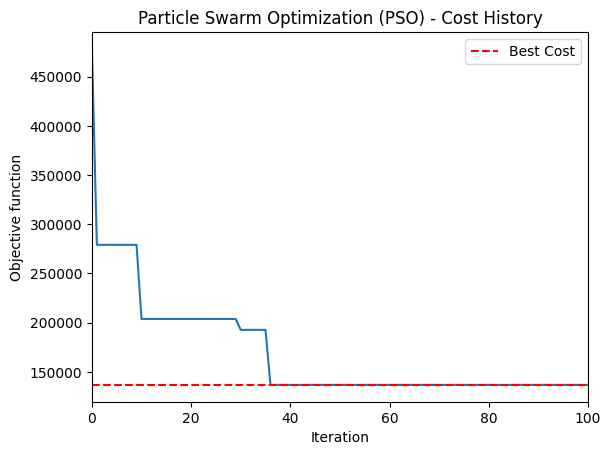

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 136756.11556788985
Tempo de Convergência para a segunda etapa: 1.185121774673462 segundos


In [24]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 1.000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

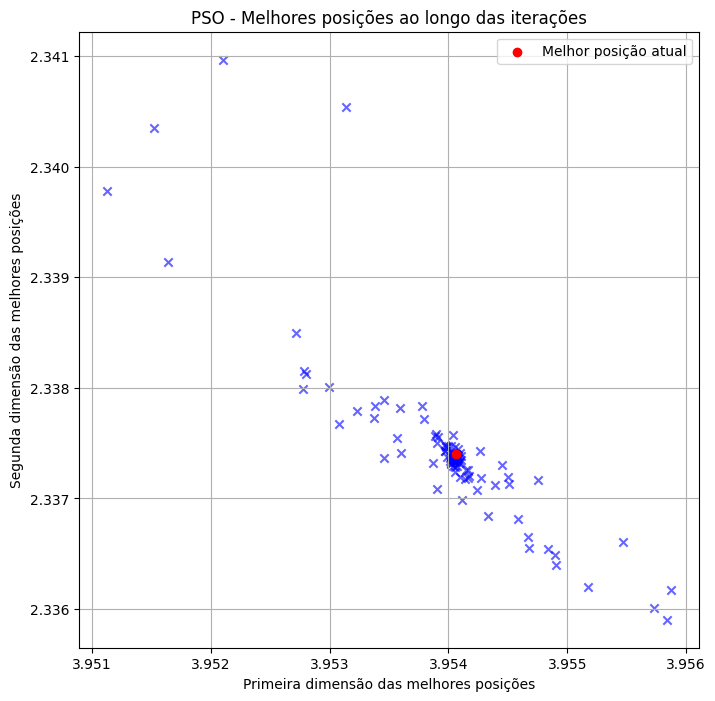

In [25]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [26]:
# # Nome do arquivo CSV para salvar o resultado do melhor custo
# nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [27]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv', sep=",")
resultado.head(10)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,4.221348e+08,123.294361,9.998092,0.288089,0.008903,1.340196,12
1,2,1.113853e+08,122.786813,9.995324,0.286275,0.005789,1.427013,8
2,3,1.059578e+08,124.352022,9.998797,0.309419,0.007851,1.646344,9
3,4,4.224613e+07,122.765793,9.998811,0.363530,0.011067,1.599882,8
4,5,1.013309e+08,120.763712,9.993543,0.417036,0.022115,1.480646,14
5,6,1.532608e+08,122.596717,9.996301,0.343962,0.016675,1.301908,5
6,7,2.052289e+08,126.031231,9.986287,0.197210,0.008348,1.487267,7
7,8,6.581563e+07,120.713917,9.991138,0.431321,0.008759,1.452315,10
8,9,1.578235e+08,123.627537,9.980213,0.276942,0.010463,1.412024,9
9,10,1.080509e+08,125.118623,9.995952,0.211524,0.011816,1.548445,8


In [40]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        10 non-null     int64  
 1   Melhor_Custo                 10 non-null     float64
 2   Lambda                       10 non-null     float64
 3   Beta                         10 non-null     float64
 4   Theta                        10 non-null     float64
 5   Convergencia_Primeira_Etapa  10 non-null     float64
 6   Convergencia_Segunda_Etapa   10 non-null     float64
 7   Ciclos_MP                    10 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 768.0 bytes


In [37]:
resultado.describe()

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,10.00000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,1.473235e+08,123.205073,9.993446,0.312531,0.011179,1.469604,9.000000
std,3.02765,1.071680e+08,1.701466,0.006043,0.077950,0.004829,0.108092,2.538591
min,1.00000,4.224613e+07,120.713917,9.980213,0.197210,0.005789,1.301908,5.000000
25%,3.25000,1.024876e+08,122.638986,9.991739,0.279276,0.008451,1.415772,8.000000
50%,5.50000,1.097181e+08,123.040587,9.995638,0.298754,0.009683,1.466480,8.500000
75%,7.75000,1.566829e+08,124.170901,9.997644,0.358638,0.011629,1.533150,9.750000
max,10.00000,4.221348e+08,126.031231,9.998811,0.431321,0.022115,1.646344,14.000000


In [38]:
colunas = ['Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

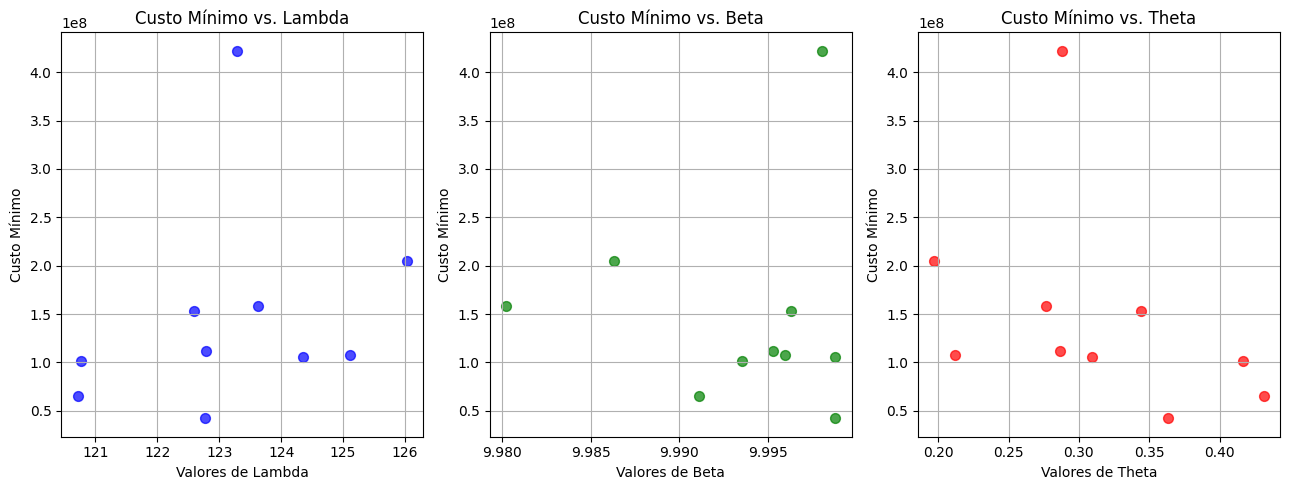

In [30]:
# Cria uma figura com três subgráficos da relação entre os os parametros Lambda, Beta e Theta com o melhor custo

fig, axes = plt.subplots(1, 3, figsize=(13, 5))

resultado.plot(kind='scatter', x='Lambda', y='Melhor_Custo', s=50, alpha=0.7, color='b', ax=axes[0])
axes[0].set_xlabel('Valores de Lambda')
axes[0].set_ylabel('Custo Mínimo')
axes[0].set_title('Custo Mínimo vs. Lambda')
axes[0].grid(True)

resultado.plot(kind='scatter', x='Beta', y='Melhor_Custo', s=50, alpha=0.7, color='g', ax=axes[1])
axes[1].set_xlabel('Valores de Beta')
axes[1].set_ylabel('Custo Mínimo')
axes[1].set_title('Custo Mínimo vs. Beta')
axes[1].grid(True)

resultado.plot(kind='scatter', x='Theta', y='Melhor_Custo', s=50, alpha=0.7, color='r', ax=axes[2])
axes[2].set_xlabel('Valores de Theta')
axes[2].set_ylabel('Custo Mínimo')
axes[2].set_title('Custo Mínimo vs. Theta')
axes[2].grid(True)

# Ajusta os espaçamentos entre subgráficos
plt.tight_layout()
plt.show()

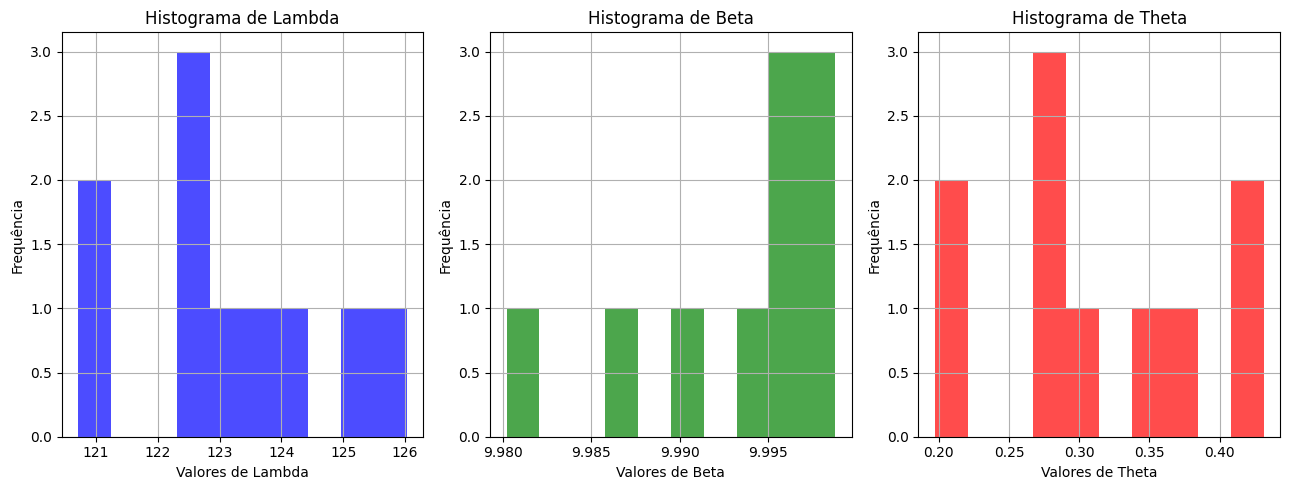

In [31]:
# Cria uma figura com três subgráficos da relação entre os os parametros Lambda, Beta e Theta com o melhor custo

fig, axs = plt.subplots(1, 3, figsize=(13, 5))

# Histograma para Lambda
axs[0].hist(resultado['Lambda'], bins=10, color='b', alpha=0.7)
axs[0].set_xlabel('Valores de Lambda')
axs[0].set_ylabel('Frequência')
axs[0].set_title('Histograma de Lambda')
axs[0].grid(True)

# Histograma para Beta
axs[1].hist(resultado['Beta'], bins=10, color='g', alpha=0.7)
axs[1].set_xlabel('Valores de Beta')
axs[1].set_ylabel('Frequência')
axs[1].set_title('Histograma de Beta')
axs[1].grid(True)

# Histograma para Theta
axs[2].hist(resultado['Theta'], bins=10, color='r', alpha=0.7)
axs[2].set_xlabel('Valores de Theta')
axs[2].set_ylabel('Frequência')
axs[2].set_title('Histograma de Theta')
axs[2].grid(True)

# Ajusta os espaçamentos entre subgráficos
plt.tight_layout()
plt.show()

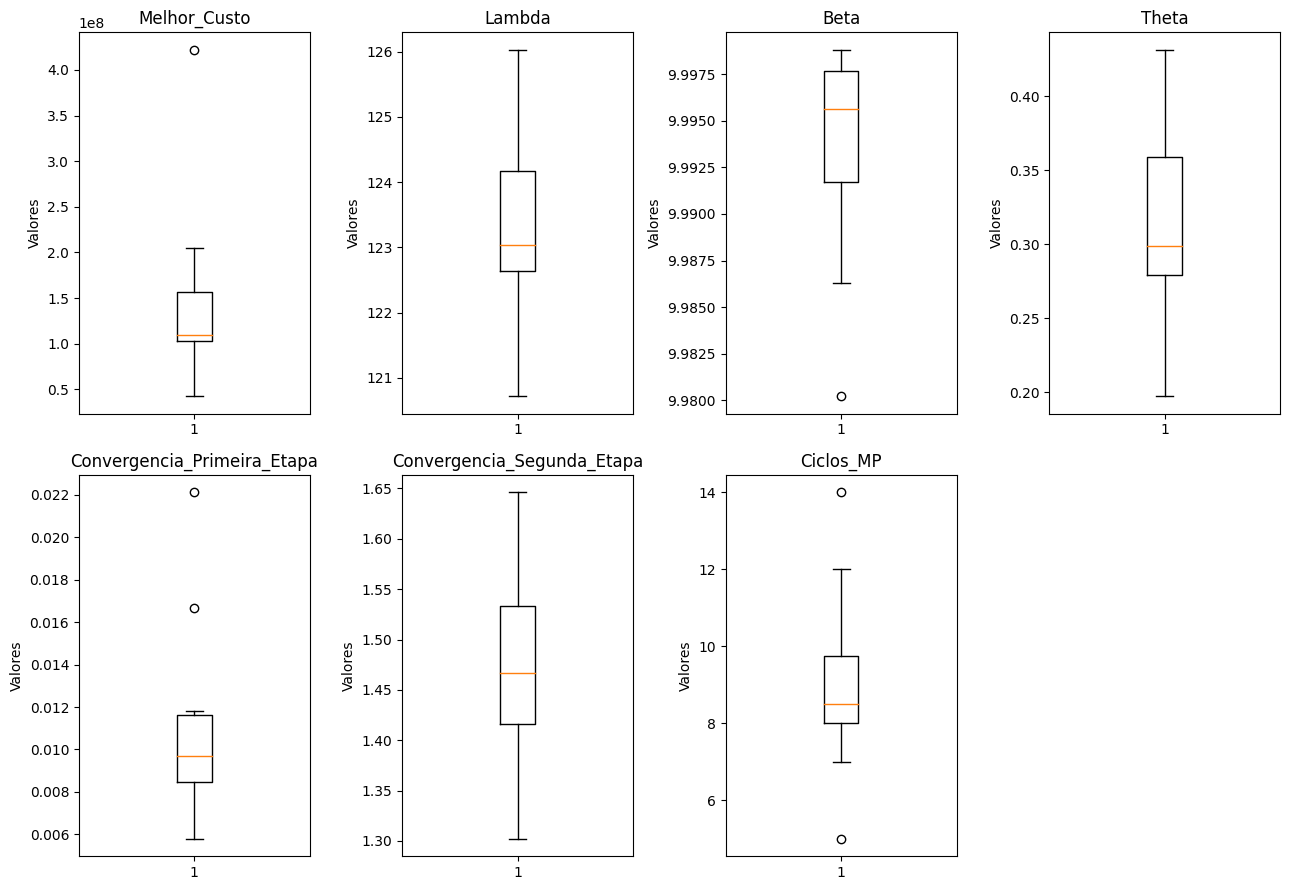

In [32]:
# Tamanho da figura
plt.figure(figsize=(13, 9))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(colunas):
    plt.subplot(2, 4, i + 1)  # 2 linhas, 4 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

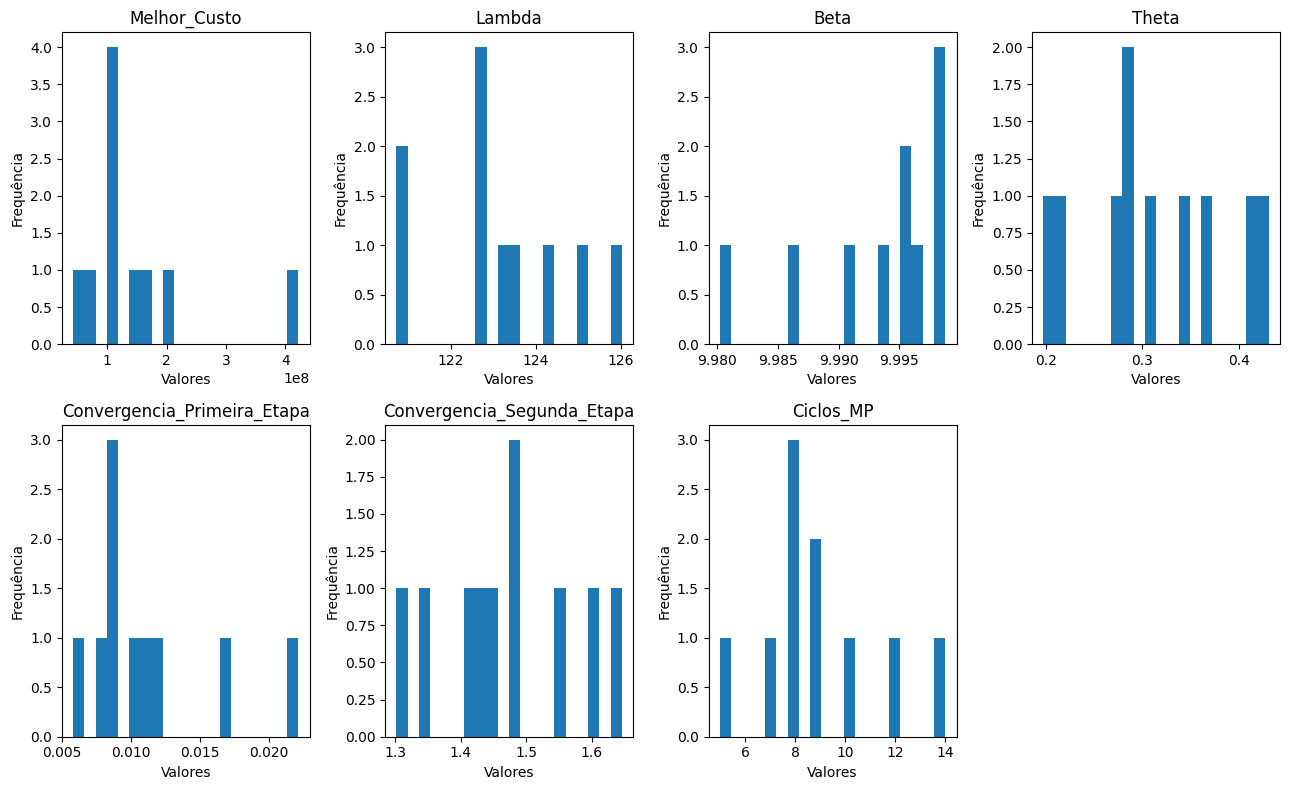

In [33]:
# Tamanho da figura
plt.figure(figsize=(13, 8))

# Itera sobre as colunas e cria um histograma para cada uma
for i, coluna in enumerate(colunas):
    plt.subplot(2, 4, i + 1)  # 2 linhas, 4 colunas de gráficos
    plt.hist(resultado[coluna], bins=20)  # Você pode ajustar o número de bins conforme necessário
    plt.title(coluna)
    plt.xlabel('Valores')
    plt.ylabel('Frequência')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [34]:
# Arrays de tempos e severidade
Tempos = [
    [[0, 75, 102, 131, 174, 238, 343, 384, 433, 490, 523, 560, 575]],
    [[0, 198, 236, 325, 330, 370, 402, 488, 518]],
    [[0, 83, 150, 188, 257, 311, 330, 385, 463, 582]],
    [[0, 5, 42, 68, 186, 215, 305, 365, 504]],
    [[0, 22, 33, 60, 104, 134, 162, 245, 325, 334, 404, 462, 500, 512, 612]],
    [[0, 10, 112, 294, 311, 663]],
    [[0, 47, 83, 137, 156, 226, 395, 637]],
    [[0, 29, 49, 97, 144, 157, 276, 318, 393, 504, 556]],
    [[0, 11, 202, 225, 261, 292, 302, 382, 504, 545]],
    [[0, 14, 62, 205, 215, 313, 340, 423, 551]],
]

severidade = [
    [[0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5]],
    [[0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25]],
    [[0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]],
    [[0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]],
    [[0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5]],
    [[0.75, 0.75, 0.75, 0.75, 0.5]],
    [[0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25]],
    [[0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75]],
    [[0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]],
    [[0.25, 0.75, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25]],
]

# Verifica se ambos os arrays têm o mesmo número de linhas
# if len(Tempos) == len(severidade):
#     with open('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenariociclo_tempo_severidade.csv', "w") as file:
#         file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
#         for i in range(len(Tempos)):
#             row = Tempos[i] + severidade[i]
#             row_str = [str(value) for value in row]
#             file.write(f"{i};{';'.join(row_str)}\n")
# else:
#     print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")


In [51]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv('/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/melhor_custo_ag_primeiro_cenariociclo_tempo_severidade.csv', sep=";")
dados.head(10)

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
0,"49, 94, 200, 349","1.0, 1.0, 1.0, 0.25"
1,"35, 99, 159, 256, 391","0.5, 1.0, 1.0, 1.0, 0.5"
2,"64, 139, 291","1.0, 1.0, 1.0"
3,"92, 126, 220, 308, 434","1.0, 1.0, 1.0, 1.0, 0.5"
4,"91, 133, 210, 349","1.0, 1.0, 1.0, 0.25"
5,"69, 119, 190, 217, 247, 353, 384, 414","0.5, 0.75, 1.0, 0.5, 0.75, 0.75, 0.75, 0.5"
6,"40, 168, 319","1.0, 1.0, 0.25"
7,"20, 103, 160, 266, 401","0.5, 1.0, 1.0, 1.0, 0.5"
8,"41, 94, 180, 328","0.75, 1.0, 1.0, 0.5"
9,"68, 151, 298","1.0, 1.0, 0.5"


In [52]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Tempos_Manutencoes_Preventivas  10 non-null     object
 1   Severidade_subsistema           10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


In [53]:
dados.describe()

,Tempos_Manutencoes_Preventivas,Severidade_subsistema
count,10,10
unique,10,8
top,"49, 94, 200, 349","1.0, 1.0, 1.0, 0.25"
freq,1,2
